# Ghana Workshop Q1. Basic Mapping for Yield Estimate with GEE
This notebook will demonstrate some basic mapping tools within GEE and geemap libraries to:
  
1) visualize the vegetation data from existing satellite products, e.g. MODIS LAI and NDVI;  
2) explore the relationship between district-level yield data and weather drivers;  
3) mask the data with classified maize layer. 


In [2]:
#from basic_plotting import *
from mofa_empirical import *
import geemap, ee
from mpl_toolkits import mplot3d
from datetime import datetime
import ipywidgets as widgets
from ipyleaflet import WidgetControl, Marker

Firstly, let's define the Map basic and Area of Interest (AOIs). You can define a simple lat/lon location with a pair of square brackets to define a Point of Interest (POI), or the lat/lon of four corners of a rectangular area. If you are interested in a particular administrative region, try the [Global Administrative Unit Layers (GAUL) polygons](https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level2?hl=en) to help define your AOI.

In [37]:
tamale_centre = [9.38, -0.68]
# alternatively, start with a GSSTI farm location with high expected yield of 1500 per acre
farm_7021YAM = [9.70065, -0.54129]

Map = geemap.Map(center=tamale_centre, zoom=9)

cities = ee.FeatureCollection("FAO/GAUL/2015/level2")
ghana_district = cities.filter(ee.Filter.eq('ADM0_NAME', 'Ghana'))
northern_district = ghana_district.filter(ee.Filter.eq('ADM1_NAME', 'Northern'))

aoi_bole = northern_district.filter(ee.Filter.eq('ADM2_NAME', 'Bole'))
aoi_tamale = northern_district.filter(ee.Filter.eq('ADM2_NAME', 'Tamale North Sub Metro'))

northern_outline = ee.Image().byte().paint(**{
  'featureCollection': northern_district,
  'color': 1,
  'width': 2
})

Map.addLayer(northern_outline, {}, 'Ghana districts')
Map

Map(center=[9.38, -0.68], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children…

Now we have set up some basic POIs, AOIs, and an outline for the Northern Districts as well. In order to visualise or refresh the GEE Map, simply call 'Map' in a code cell:

## Load MODIS data collections from GEE
Next, let's load some MODIS data for Northern Ghana. I've defined here a python function called `load_modis_band` to do so. It automatically loads the [MODIS MOD13Q1 NDVI/EVI](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13Q1), the [MODIS MCD15A3H Lai](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MCD15A3H) or the [MODIS MCD12Q1 LandCover](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MCD12Q1) image collections from GEE's data catalog and also calculates the annual means values for the specific band for a specific year. 

In [9]:
def plot_modis_band(band='Lai', year=2018, reducer = 'mean'):
    
    band_yearly, band_reduced = load_modis_band(band, year, northern_district, reducer)

    #Map = geemap.Map(center=farm_7021YAM, zoom=9)
    Map.addLayer(band_reduced, colorized_vis['Lai'], f'{reducer} {band} {year}')
    Map.addLayer(outline, {}, 'Ghana districts')
    return band_yearly
    
lai_2018 = plot_modis_band(band='Lai', year=2018)

MODIS Lai and mean both SUCCESS for 2018


In [5]:
print(lai_2018.first().getInfo())

{'type': 'Image', 'bands': [{'id': 'Lai', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 25.5}, 'crs': 'SR-ORG:6974', 'crs_transform': [463.312716528, 0, -20015109.354, 0, -463.312716527, 10007554.677]}], 'properties': {'system:index': '2018_06_02'}}


In [6]:
print(lai_2018.first().get('system:index').getInfo())

2018_06_02


# Use MODIS land cover "grassland (including cereal crops)" as masks

In [7]:
lc_crop, lc_all = load_modis_lc('LC_Type3', 2018, northern_district, cropclasses=[1])
Map.addLayer(lc_crop, {'min':0, 'max':1}, f"GrasslandsType3 2018", opacity=0.7)

MODIS LC_Type3 and mean both SUCCESS for 2018


In [6]:
lc_crop, lc_all = load_modis_lc('LC_Type2', 2018, northern_district, cropclasses=[10])
Map.addLayer(lc_crop, {'min':0, 'max':1}, f"GrasslandsType2 2018", opacity=0.7)

MODIS LC_Type2 and mean both SUCCESS for 2018


In [5]:
print(lai_2018.first().getInfo())
date = lai_2018.first().get('system:index').getInfo()
#refresh_base_map()
Map.addLayer(lai_2018.first().clip(aoi_tamale), colorized_vis['Lai'], f'Lai {date}')
Map

{'type': 'Image', 'bands': [{'id': 'Lai', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 25.5}, 'crs': 'SR-ORG:6974', 'crs_transform': [463.312716528, 0, -20015109.354, 0, -463.312716527, 10007554.677]}], 'properties': {'system:index': '2018_06_02'}}


Map(center=[9.38, -0.68], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children…

In [7]:
def return_time_series_of_aoi(image):
    d = image.reduceRegion(reducer=ee.Reducer.median(), geometry=aoi_tamale, scale=500)
    return image.set(d)

def return_time_series_of_poi(image):
    d = image.reduceRegion(reducer=ee.Reducer.median(), geometry=ee.Geometry.Point(farm_7021YAM), scale=500)
    return image.set(d)

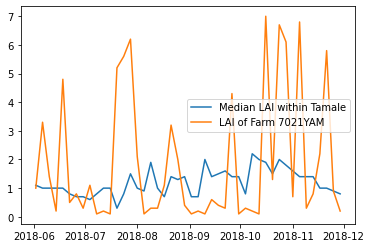

In [8]:
dates_str = lai_2018.reduceColumns( ee.Reducer.toList(1), ['system:index'] ).values().get(0).getInfo()
dates = [datetime.strptime(date[0], "%Y_%m_%d") for date in dates_str]

lai_ts = lai_2018.map(return_time_series_of_aoi)
lai_array = lai_ts.aggregate_array('Lai').getInfo()
plt.plot_date(dates, lai_array, linestyle='solid', marker='None', label='Median LAI within Tamale')

lai_ts = lai_2018.map(return_time_series_of_poi)
lai_array = lai_ts.aggregate_array('Lai').getInfo()
plt.plot_date(dates, lai_array, linestyle='solid', marker='None', label='LAI of Farm 7021YAM')

plt.legend(loc='best')
plt.savefig("tamale_meadian_lai_2018.png")

In [9]:
nested_lai = lai_2018.reduceColumns( ee.Reducer.toList(1), ['system:index'] ).values().get(0) 

df = pd.DataFrame(nested_lai.getInfo(), columns=['system:index'])

df.head()

system:index
0   2018_06_02
1   2018_06_06
2   2018_06_10
3   2018_06_14
4   2018_06_18

In [34]:
qc, qc_mean = load_modis_band('FparLai_QC', 2006, aoi_tamale, 'mean')
Map.addLayer(qc.first().clip(aoi_tamale), {}, 'QC 2018 06 02')

MODIS FparLai_QC and mean both SUCCESS for 2006


In [33]:
maskSize = ee.Number(1).add(0).subtract(0)
print(maskSize.getInfo())
mask = ee.Number(1).leftShift(maskSize).subtract(1)
print(mask.getInfo())

result = qa_test.rightShift(0).bitwiseAnd(mask)
Map.addLayer(result, {}, 'QC test 1')

1
1


In [39]:
qa_test = qc.first().clip(aoi_tamale)
good = bitwiseExtract(qa_test, 0)
qa_test.updateMask(not(good))

Map.addLayer(qa_test, {}, 'QC test')
Map

Map(center=[9.38, -0.68], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children…

In [54]:
qc_mean.select('FparLai_QC').getInfo()

{'type': 'Image',
 'bands': [{'id': 'FparLai_QC',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': 0,
    'max': 255},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

In [27]:
qc.first().getInfo()

{'type': 'Image',
 'bands': [{'id': 'FparLai_QC',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 255},
   'dimensions': [86400, 43200],
   'crs': 'SR-ORG:6974',
   'crs_transform': [463.3127165279165,
    0,
    -20015109.353988,
    0,
    -463.3127165274999,
    10007554.676994]}],
 'version': 1638755496347587,
 'id': 'MODIS/006/MCD15A3H/2006_06_02',
 'properties': {'system:time_start': 1149206400000,
  'google:max_source_file_timestamp': 1494550233865,
  'system:footprint': {'type': 'LinearRing',
   'coordinates': [[-180, -90],
    [180, -90],
    [180, 90],
    [-180, 90],
    [-180, -90]]},
  'system:time_end': 1149552000000,
  'system:asset_size': 1570172584,
  'system:index': '2006_06_02'}}

In [64]:
def seasonal_lai_per_district(district = 'Tamale', years=[2018], REDUCER = 'mean', \
                              toPlot=True, useSubplots=True, onlyCropland=True, applyQA=False):
    
    lai_all_seasons = []
    dates_all_seasons = []
    
    if district=='Tamale': 
        district = 'Tamale North Sub Metro'
        
    if district == 'ALL_DISTRICTS':
        aoi = northern_district
    else:
        aoi = northern_district.filter(ee.Filter.eq('ADM2_NAME', district))
    
    if toPlot and useSubplots:
        fig, axes = plt.subplots(math.ceil(len(years) / 3), 3, figsize=(24, 16), sharex=False, sharey=True)
        fig_title = f'{REDUCER} LAI of {district}'
        if onlyCropland:
            fig_title = fig_title + ' (cropland only)'
        if applyQA:
            fig_title = fig_title + ', QA filtered'
        plt.setp(axes[-1, :], xlabel='Lai')
        plt.setp(axes[:, 0], ylabel='Date')  # not intergers due to rescaled to 500m. counts intersects
        axes = axes.flatten()
    
    for i, year in enumerate(years):
    
        if toPlot: # to add to GEE Map
            lai_one_season = plot_modis_band(band='Lai', year=year, reducer=REDUCER)
        else:
            lai_one_season, lai_seasonal_mean = load_modis_band('Lai', year, aoi, REDUCER, applyQA=applyQA)
            
        if onlyCropland:
            lc_crop, lc_all = load_modis_lc('LC_Type2', year, aoi, cropclasses=[10])
            lai_one_season = lai_one_season.map(lambda image: image.mask(lc_crop))
        
        dates_str = lai_one_season.reduceColumns( ee.Reducer.toList(1), ['system:index'] ).values().get(0).getInfo()
        dates = [datetime.strptime(date[0], "%Y_%m_%d") for date in dates_str]
        dates_all_seasons.append(dates)
        
        def return_reduced_time_series(image):            
            space_methods = {'mean': ee.Reducer.mean, \
                             'max': ee.Reducer.max, \
                             'min': ee.Reducer.min, \
                             'median': ee.Reducer.median}
            d = image.reduceRegion(reducer=space_methods[REDUCER](), geometry=aoi, scale=500)
            return image.set(d)
       
        lai_ts = lai_one_season.map(return_reduced_time_series)
        lai_array = lai_ts.aggregate_array('Lai').getInfo()
        lai_all_seasons.append(lai_array)
        
        short_name = ''.join(district.split(' ')).replace('/', '_')
        
        if toPlot:
            if useSubplots:
                axes[i].plot_date(dates, lai_array, label=f'{REDUCER} LAI within {short_name} {year}')        
                #axes[i].figure.savefig(f"{short_name}_meadian_lai_{year}.png")
                axes[i].legend(loc='best')
            else:
                plt.figure()
                plt.plot_date(dates, lai_array, label=f'{REDUCER} LAI within {short_name} {year}')        
                plt.savefig(f"{short_name}_{REDUCER}_lai_{year}.png")
                plt.legend(loc='best')
                plt.title(f'{REDUCER} LAI of {short_name} {year}')
    out_fn = f'LAI_{REDUCER}_{short_name}_{years[0]}-{years[-1]}'
    if onlyCropland:
        out_fn = out_fn + '_croplandOnly'
    if applyQA:
        out_fn = out_fn + '_QAfiltered'
    np.savez(out_fn + '.npz', dates_all_seasons, lai_all_seasons)
    return lai_all_seasons, dates_all_seasons

MODIS Lai and mean both SUCCESS for 2006
MODIS Lai and mean both SUCCESS for 2007
MODIS Lai and mean both SUCCESS for 2008
MODIS Lai and mean both SUCCESS for 2009
MODIS Lai and mean both SUCCESS for 2010
MODIS Lai and mean both SUCCESS for 2011
MODIS Lai and mean both SUCCESS for 2012
MODIS Lai and mean both SUCCESS for 2013
MODIS Lai and mean both SUCCESS for 2014
MODIS Lai and mean both SUCCESS for 2015
MODIS Lai and mean both SUCCESS for 2016
MODIS Lai and mean both SUCCESS for 2017
MODIS Lai and mean both SUCCESS for 2018
MODIS Lai and mean both SUCCESS for 2019


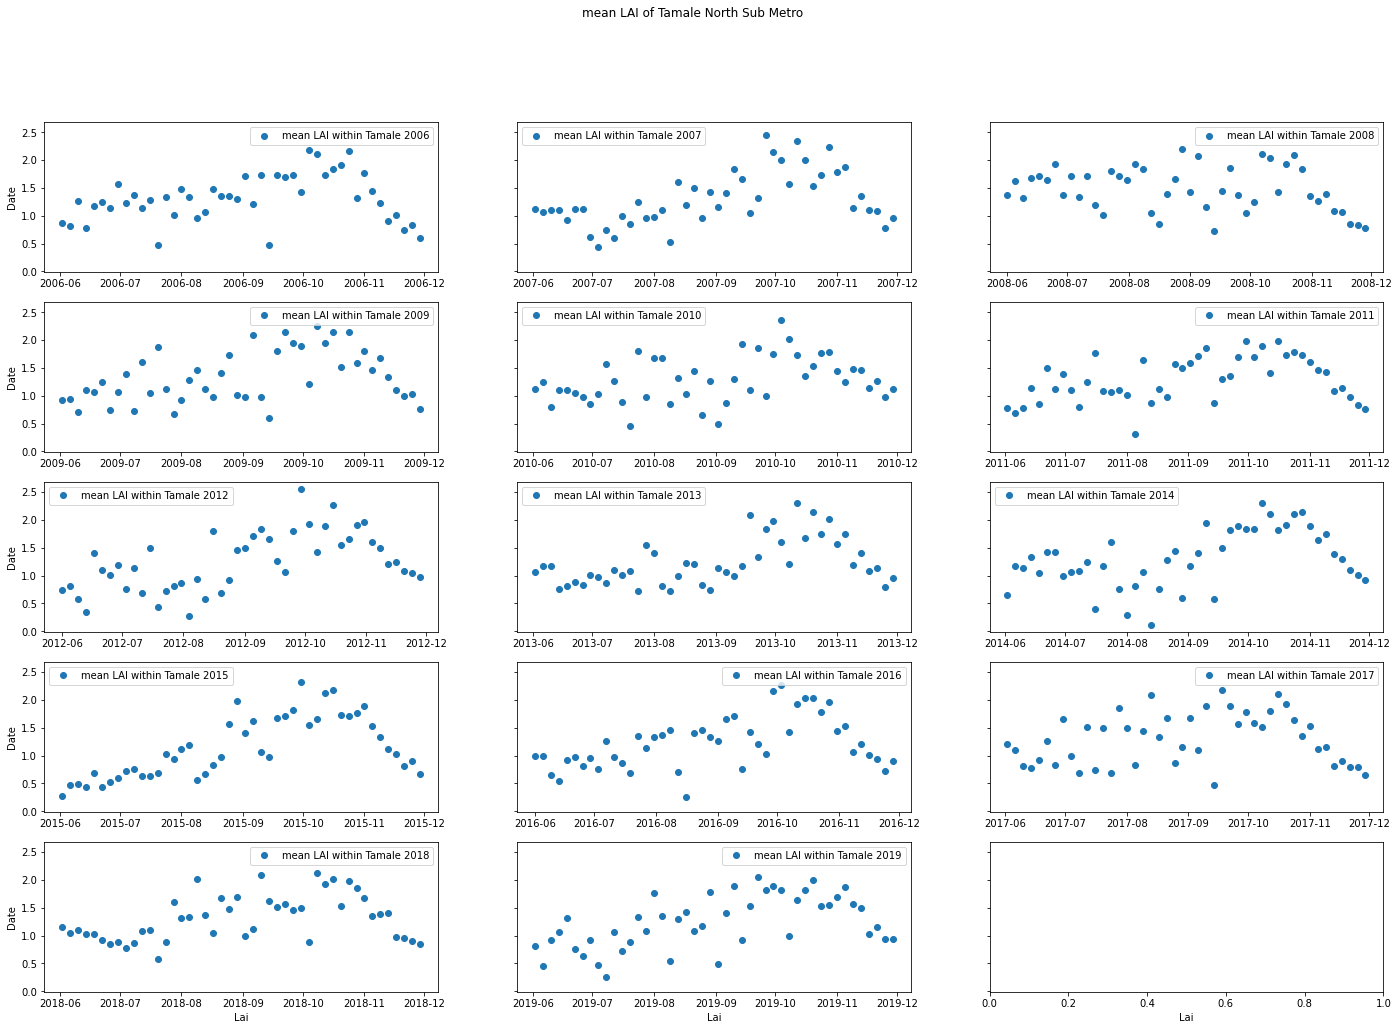

In [14]:
lai_tamale_mean, dates_all_seasons = seasonal_lai_per_district(district = 'Tamale', years=range(2006,2020), \
                                                               useSubplots=True, onlyCropland=False, applyQA=True)

MODIS Lai and mean both SUCCESS for 2006
MODIS LC_Type2 and mean both SUCCESS for 2006
MODIS Lai and mean both SUCCESS for 2007
MODIS LC_Type2 and mean both SUCCESS for 2007
MODIS Lai and mean both SUCCESS for 2008
MODIS LC_Type2 and mean both SUCCESS for 2008
MODIS Lai and mean both SUCCESS for 2009
MODIS LC_Type2 and mean both SUCCESS for 2009
MODIS Lai and mean both SUCCESS for 2010
MODIS LC_Type2 and mean both SUCCESS for 2010
MODIS Lai and mean both SUCCESS for 2011
MODIS LC_Type2 and mean both SUCCESS for 2011
MODIS Lai and mean both SUCCESS for 2012
MODIS LC_Type2 and mean both SUCCESS for 2012
MODIS Lai and mean both SUCCESS for 2013
MODIS LC_Type2 and mean both SUCCESS for 2013
MODIS Lai and mean both SUCCESS for 2014
MODIS LC_Type2 and mean both SUCCESS for 2014
MODIS Lai and mean both SUCCESS for 2015
MODIS LC_Type2 and mean both SUCCESS for 2015
MODIS Lai and mean both SUCCESS for 2016
MODIS LC_Type2 and mean both SUCCESS for 2016
MODIS Lai and mean both SUCCESS for 2017
MO

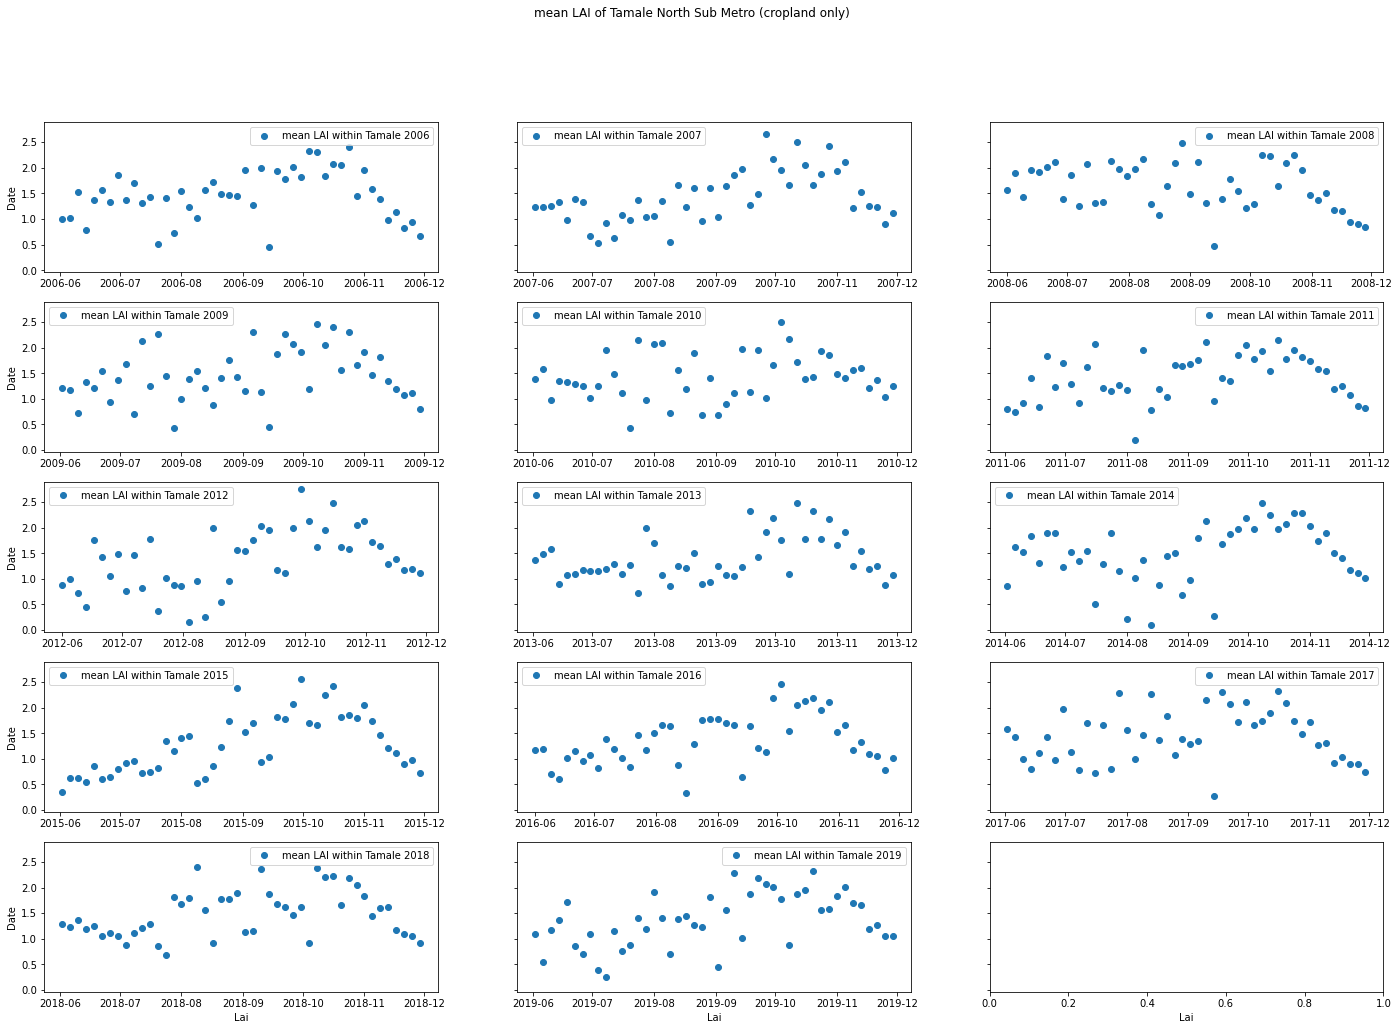

In [9]:
lai_tamale_mean_croplandonly, dates_all_seasons = seasonal_lai_per_district(district = 'Tamale', years=range(2006,2020), \
                                                               useSubplots=True, onlyCropland=True)

MODIS Lai and mean both SUCCESS for 2006
MODIS Lai and mean both SUCCESS for 2007
MODIS Lai and mean both SUCCESS for 2008
MODIS Lai and mean both SUCCESS for 2009
MODIS Lai and mean both SUCCESS for 2010
MODIS Lai and mean both SUCCESS for 2011
MODIS Lai and mean both SUCCESS for 2012
MODIS Lai and mean both SUCCESS for 2013
MODIS Lai and mean both SUCCESS for 2014
MODIS Lai and mean both SUCCESS for 2015
MODIS Lai and mean both SUCCESS for 2016
MODIS Lai and mean both SUCCESS for 2017
MODIS Lai and mean both SUCCESS for 2018
MODIS Lai and mean both SUCCESS for 2019


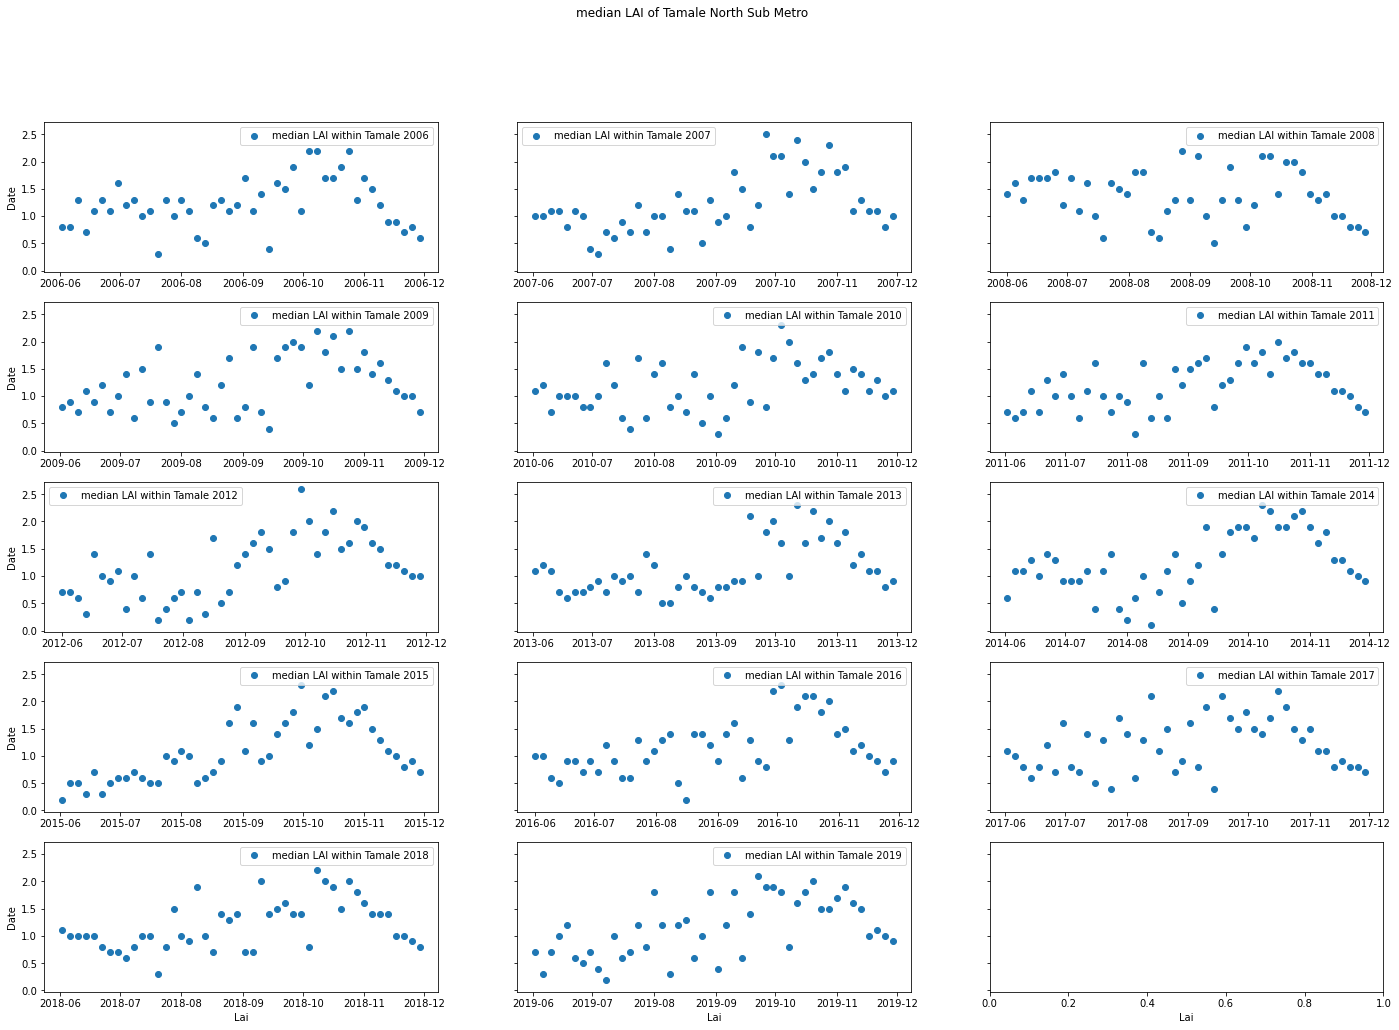

In [10]:
lai_tamale_median, dates_all_seasons = seasonal_lai_per_district(district = 'Tamale', years=range(2006,2020), \
                                                                 REDUCER='median', useSubplots=True,\
                                                                onlyCropland=False)

MODIS Lai and mean both SUCCESS for 2006
MODIS LC_Type2 and mean both SUCCESS for 2006
MODIS Lai and mean both SUCCESS for 2007
MODIS LC_Type2 and mean both SUCCESS for 2007
MODIS Lai and mean both SUCCESS for 2008
MODIS LC_Type2 and mean both SUCCESS for 2008
MODIS Lai and mean both SUCCESS for 2009
MODIS LC_Type2 and mean both SUCCESS for 2009
MODIS Lai and mean both SUCCESS for 2010
MODIS LC_Type2 and mean both SUCCESS for 2010
MODIS Lai and mean both SUCCESS for 2011
MODIS LC_Type2 and mean both SUCCESS for 2011
MODIS Lai and mean both SUCCESS for 2012
MODIS LC_Type2 and mean both SUCCESS for 2012
MODIS Lai and mean both SUCCESS for 2013
MODIS LC_Type2 and mean both SUCCESS for 2013
MODIS Lai and mean both SUCCESS for 2014
MODIS LC_Type2 and mean both SUCCESS for 2014
MODIS Lai and mean both SUCCESS for 2015
MODIS LC_Type2 and mean both SUCCESS for 2015
MODIS Lai and mean both SUCCESS for 2016
MODIS LC_Type2 and mean both SUCCESS for 2016
MODIS Lai and mean both SUCCESS for 2017
MO

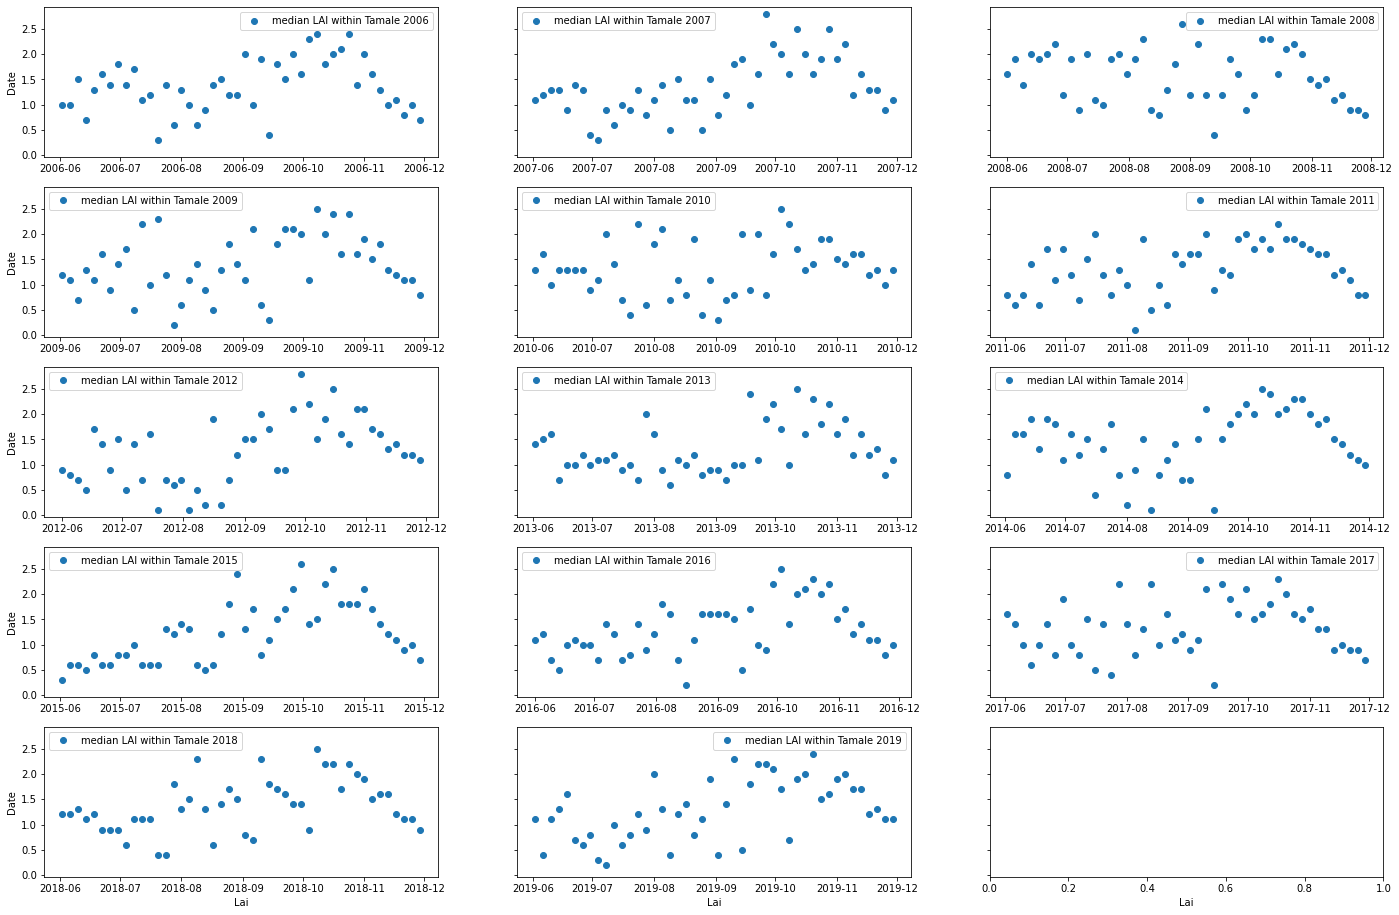

In [40]:
lai_tamale_median_croplandonly, dates_all_seasons = seasonal_lai_per_district(district = 'Tamale', years=range(2006,2020), \
                                                               REDUCER='median',\
                                                                useSubplots=True, onlyCropland=True, applyQA=False)

In [12]:
np.array(lai_tamale_median).shape

(14, 46)

In [13]:
np.array(lai_tamale_mean).shape

(14, 46)

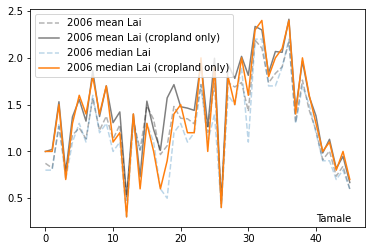

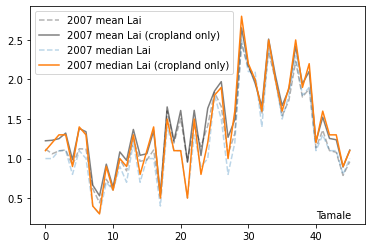

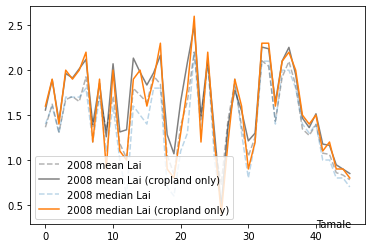

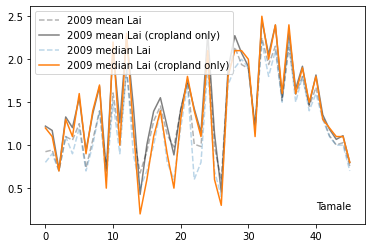

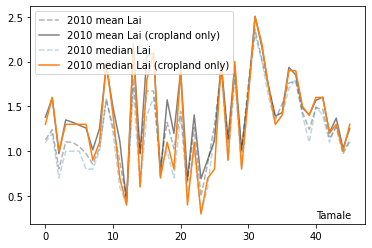

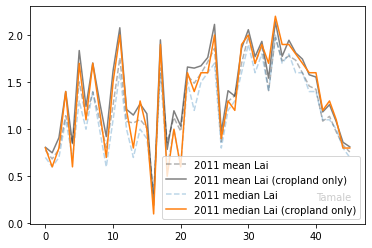

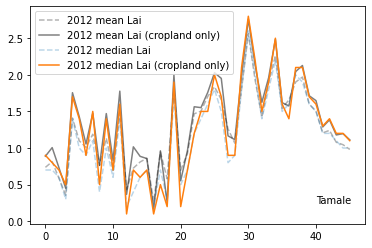

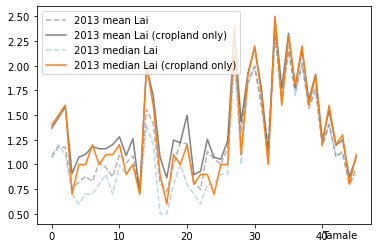

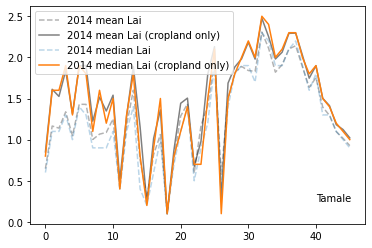

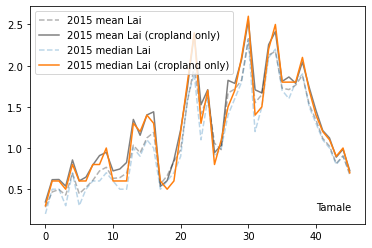

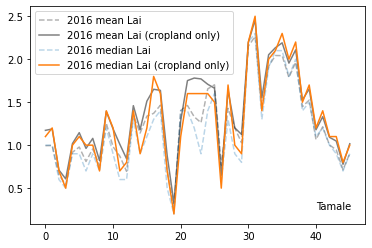

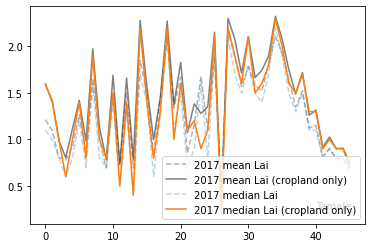

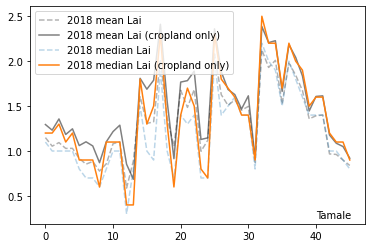

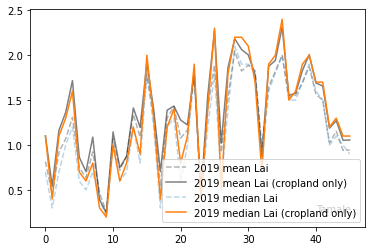

In [14]:
years=range(2006,2020)

for i, year in enumerate(years):
    plt.figure()
    plt.plot(lai_tamale_mean[i], 'k--', label=f"{year} mean Lai", alpha=0.3)
    plt.plot(lai_tamale_mean_croplandonly[i], 'k', label=f"{year} mean Lai (cropland only)", alpha=0.5)        

    plt.plot(lai_tamale_median[i] , '--', label=f"{year} median Lai", alpha=0.3)
    plt.plot(lai_tamale_median_croplandonly[i] , label=f"{year} median Lai (cropland only)")
    plt.legend(loc='best')
    plt.text(40, 0.25, 'Tamale')
    
    

# Compare to ERA5 time series

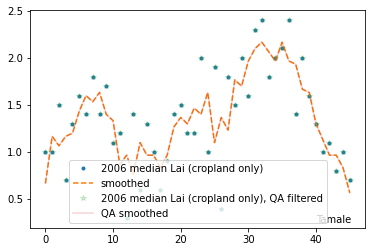

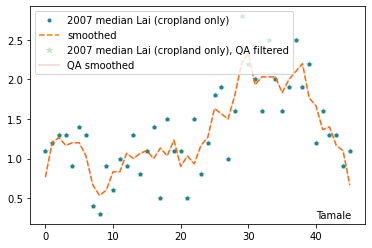

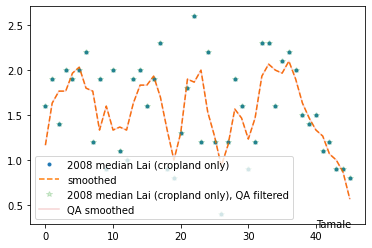

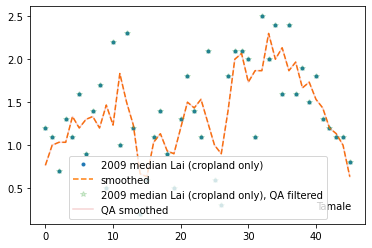

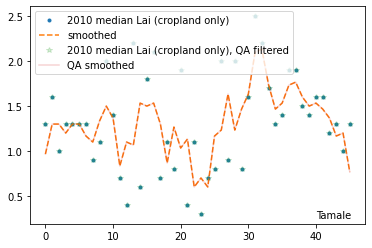

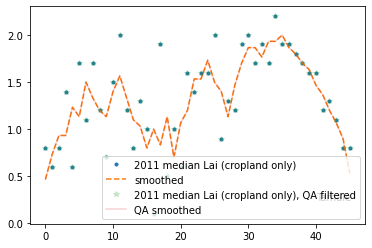

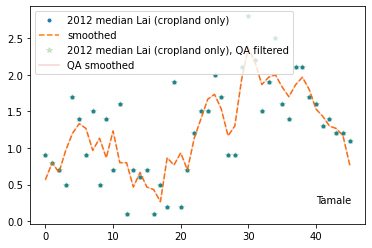

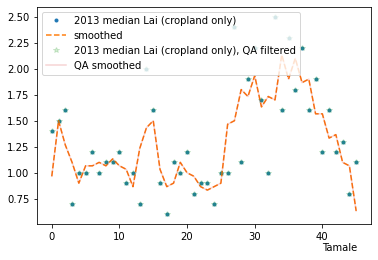

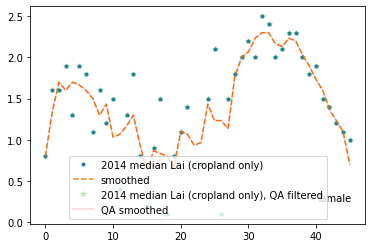

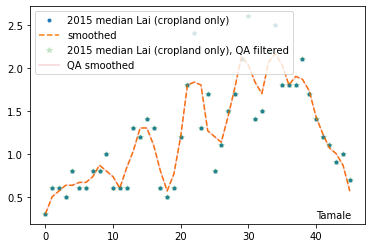

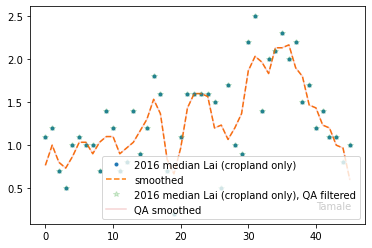

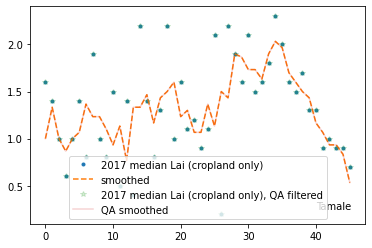

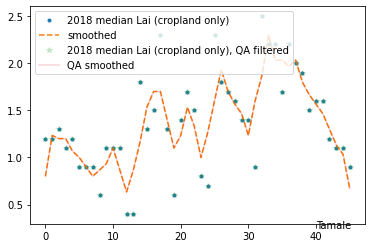

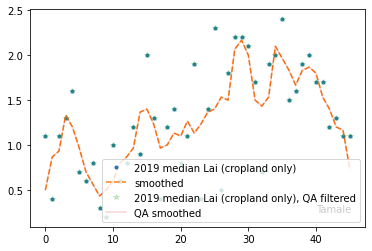

In [45]:
years=range(2006,2020)

npzfile = np.load('LAI_median_Tamale_2006-2019_croplandOnly.npz', allow_pickle=True)
#print(npzfile.files)
lai_tamale_median_croplandonly = npzfile.f.arr_1
dates_all_seasons = npzfile.f.arr_0

npzfile_qa = np.load('LAI_median_Tamale_2006-2019_croplandOnly_QAfiltered.npz', allow_pickle=True)
#print(npzfile_qa.files)
lai_tamale_median_cropland_qa = npzfile_qa.f.arr_1
dates_all_seasons = npzfile_qa.f.arr_0

lai_smoothed = []

for i, year in enumerate(years):
    plt.figure()
    
    plt.plot(lai_tamale_median_croplandonly[i], '.' , label=f"{year} median Lai (cropland only)")
    smoothed_lai = np.convolve(lai_tamale_median_croplandonly[i], [1/3,1/3,1/3], mode='same')
    plt.plot(smoothed_lai, '--',label='smoothed')
    
    
    plt.plot(lai_tamale_median_cropland_qa[i], '*' , label=f"{year} median Lai (cropland only), QA filtered", alpha=0.2)    
    smoothed_lai = np.convolve(lai_tamale_median_cropland_qa[i], [1/3,1/3,1/3], mode='same')
    plt.plot(smoothed_lai, label='QA smoothed', alpha=0.2)
    
    plt.legend(loc='best')
    plt.text(40, 0.25, 'Tamale')
    
    lai_smoothed.append(smoothed_lai)

In [66]:
era5_in_season = load_era_band('total_precipitation', 2006, aoi_tamale)
print(era5_in_season.size().getInfo())
#era5_seasonal_accum = era5_in_season.sum()

6


In [73]:
years=range(2006,2020)

era5_temp = []
era5_prec = []

for year in years:
    list_of_districts, accum_temp = era4_value_per_district(year, aoi_tamale, band='temperature_2m')
    mean_temp = accum_temp / 6 -273.15 # six monthly temp
    
    list_of_districts, accum_prec = era4_value_per_district(year, aoi_tamale, band='total_precipitation')
    
    era5_temp.append(mean_temp[0])
    era5_prec.append(accum_prec[0])
print(era5_temp)
print(era5_prec)

[26.845621579628926, 26.8764055916011, 26.555181287927383, 26.814006768821343, 26.481801917720134, 26.833230585189824, 26.84823279762037, 27.07182650032371, 27.17301692986109, 27.25299971839746, 27.125120687074116, 27.212181192658534, 26.775804821356985, 26.845071225324716]
[0.021325820973350087, 0.02793190791967521, 0.028356606457819875, 0.0264814207713016, 0.030213789900665446, 0.021977213375753504, 0.019953508451911475, 0.01790985703420049, 0.024082435710232657, 0.021285753584124083, 0.02585119000697423, 0.021770385883173118, 0.030931184569479984, 0.028939197613155603]


In [104]:
df = pd.read_csv('../../Empirical-yield/Ghana-Crop-Empirical-yield/Ghana_Distirct_level_Crop_Yield_Data-upto2018_NORTHERN-ONLY.csv', sep=',', header=0)

#df = df.replace('Tamale Metro','Tamale North Sub Metro')

df_tamale_maize = df[(df['CROP']=='MAIZE') & (df['DISTRICT']=='Tamale Metro')]
df_tamale_maize

REGION      DISTRICT  YEAR   CROP  YIELD SAVANNAH
55   NORTHERN   Tamale Metro  2006  MAIZE   1.50      NaN
116  NORTHERN   Tamale Metro  2007  MAIZE   1.08      NaN
176  NORTHERN   Tamale Metro  2008  MAIZE   1.90      NaN
236  NORTHERN   Tamale Metro  2009  MAIZE   1.60      NaN
296  NORTHERN   Tamale Metro  2010  MAIZE   1.70      NaN
356  NORTHERN   Tamale Metro  2011  MAIZE   1.24      NaN
418  NORTHERN   Tamale Metro  2012  MAIZE   1.28      NaN
484  NORTHERN   Tamale Metro  2013  MAIZE   1.11      NaN
550  NORTHERN   Tamale Metro  2014  MAIZE   1.21      NaN
616  NORTHERN   Tamale Metro  2015  MAIZE   1.71      NaN
682  NORTHERN   Tamale Metro  2016  MAIZE   1.80      NaN
701  NORTHERN   Tamale Metro  2017  MAIZE   1.40      NaN
722  NORTHERN   Tamale Metro  2018  MAIZE   2.00      NaN

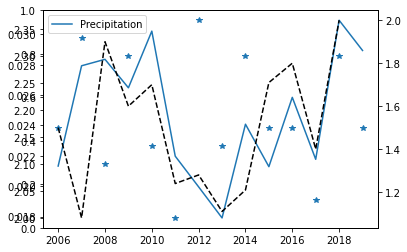

In [136]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax2.twinx()
ax4 = ax3.twinx()

ax1.plot(years, era5_prec, label='Precipitation')
ax2.plot(years, np.array(lai_smoothed).max(axis=1),'*', label='Max LAI (smoothed)')
#ax3.plot(years,era5_temp)
ax4.plot(df_tamale_maize['YEAR'], df_tamale_maize['YIELD'], 'k--', label='MOFA Yield')

ax1.legend(loc='best')

Text(1.8, 0.018, 'R2=-25.05')

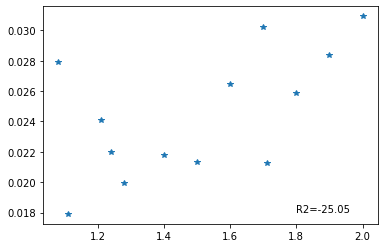

In [130]:
from sklearn.metrics import r2_score

plt.plot(df_tamale_maize['YIELD'], era5_prec[:-1], '*')
plt.text(1.8, 0.018, f"R2={r2_score(df_tamale_maize['YIELD'], era5_prec[:-1]):.2f}")

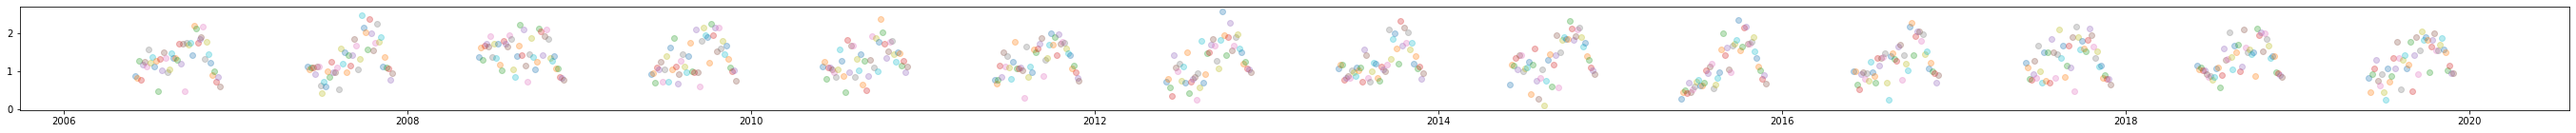

In [98]:
plt.figure(figsize=(48,2))
plt.plot_date(dates_all_seasons, lai_tamale_mean, label=f"{years[0]} to {years[-1]} mean Lai", alpha=0.3)
# plot MOFA yield next
print

# define a func to return lai time series for several years

In [ ]:
def lai_ts_per_district(years, aoi, CROPONLY=False):
    for year in years: 
        #reduce to per district values (district_names should be constant over years)
        district_names, reduced_VI_per_district = modis_vi_per_district_cropmask(year, 'Lai', aoi, \
                                                                    TIME_REDUCER='max', SPACE_DERUCER='mean',\
                                                                    CROP_ONLY=CROPONLY, ADD_TO_MAP=False)
        #print(type(mean_VI_per_district))
        if year == years[0]: 
            max_lai = reduced_VI_per_district
            #print(type(mean_ndvi), mean_ndvi.size)
        else: max_lai = np.vstack((max_lai, reduced_VI_per_district))

    max_lai = np.transpose(max_lai)

    plt.figure(figsize=(16,12))

    for i, district in enumerate(district_names):
        plt.plot(years, max_lai[i], label=district)
    if CROPONLY:
        plt.title('Max LAI per district (Croplands only)')
    else: 
        plt.title('Max LAI per district (all land covers)')
    plt.legend()  
    
    return district_names, max_lai

In [67]:
df_crop_area = pd.read_csv('crop_area-Jose.csv', dtype={'name_adm2': str, 'maiz_r': np.float64})
df_crop_area = df_crop_area.sort_values('maiz_r')
df_crop_area

name_adm2   maiz_r
113        Kumasi     11.0
112         Accra     26.0
111          Tema    251.9
110       Kwabere    989.2
109   Dangbe East   1098.1
..            ...      ...
4    Afram Plains  30002.2
3          Dormaa  30935.9
2         Sunyani  33962.3
1        Nkoranza  34517.1
0        Kintampo  41868.6

[114 rows x 2 columns]

In [71]:
from os.path import exists

def plot_district_ts(district = 'Tamale North Sub Metro', years = range(2006,2020)):
    '''district should be either an individual district name found in GAUL ADM2_NAMEs, or ="ALL_DISTRICTS"'''
    
    if district == 'ALL_DISTRICTS':
        aoi = northern_district
    else:
        aoi = northern_district.filter(ee.Filter.eq('ADM2_NAME', district))
    short_name = ''.join(district.split(' ')).replace('/', '_')

    fn = f'LAI_median_{short_name}_2006-2019_croplandOnly_QAfiltered.npz'
    if exists(fn):
        print('File already exists? Yerp')
        npzfile = np.load(fn, allow_pickle=True)
        lai = npzfile.f.arr_1
    else:
        lai, dates = seasonal_lai_per_district(district = district, years=years, REDUCER='median', \
                                           useSubplots=True, onlyCropland=True, applyQA=True)

    lai_smoothed = []
    era5_temp = []
    era5_prec = []

    for i, year in enumerate(years):
        smoothed_lai = np.convolve(lai[i], [1/3,1/3,1/3], mode='same')
        lai_smoothed.append(smoothed_lai)

        list_of_districts, accum_temp = era4_value_per_district(year, aoi, band='temperature_2m')
        mean_temp = accum_temp / 6 -273.15 # six monthly temp

        list_of_districts, accum_prec = era4_value_per_district(year, aoi, band='total_precipitation')

        era5_temp.append(mean_temp[0])
        era5_prec.append(accum_prec[0])
    #print(era5_temp)
    #print(era5_prec)

    df = pd.read_csv('../../Empirical-yield/Ghana-Crop-Empirical-yield/Ghana_Distirct_level_Crop_Yield_Data-upto2018_NORTHERN-ONLY.csv', sep=',', header=0)
    df = df.replace('Tamale Metro','Tamale North Sub Metro')   
    df = df.replace('Central Gonja','Gonja Central')
    df = df.replace('East Mamprusi','Mamprusi East')
    df = df.replace('Tamale Metro','Tamale North Sub Metro')
    df = df.replace('Yendi','Yendi Municipal')
    
    if district == 'ALL_DISTRICTS':
        df_maize = df[(df['CROP']=='MAIZE') & (df['REGION']=='NORTHERN ')] 
    else:
        df_maize = df[(df['CROP']=='MAIZE') & (df['DISTRICT']==district)]

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax2._get_lines.prop_cycler = ax1._get_lines.prop_cycler
    ax3 = ax1.twinx()
    ax3._get_lines.prop_cycler = ax2._get_lines.prop_cycler
    #ax4 = ax3.twinx()

    lns1 = ax1.plot(years, era5_prec, label='Precipitation')
    #ax3.plot(years,era5_temp)
    lns2 = ax2.plot(df_maize['YEAR'], df_maize['YIELD'], 'k--', label='MOFA Yield')
    lns3 = ax3.plot(years, np.array(lai_smoothed).max(axis=1),'*', label='Max LAI (smoothed)')
    ax3.get_yaxis().set_visible(False)
    
    fig.suptitle(district)
    
    # added these three lines
    lns = lns1+lns2+lns3
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=0)
    
    plt.savefig(f'Qtrend_{short_name}.png')
    

File already exists? Yerp


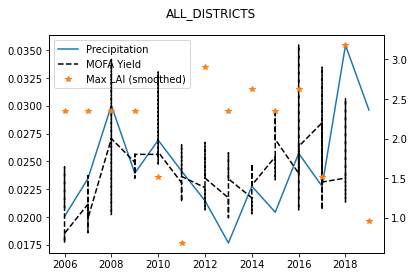

In [75]:
# generate an overall trend for all district as dummy.png
plot_district_ts(district = 'ALL_DISTRICTS')    

MODIS Lai and mean both SUCCESS for 2006
MODIS LC_Type2 and mean both SUCCESS for 2006
MODIS Lai and mean both SUCCESS for 2007
MODIS LC_Type2 and mean both SUCCESS for 2007
MODIS Lai and mean both SUCCESS for 2008
MODIS LC_Type2 and mean both SUCCESS for 2008
MODIS Lai and mean both SUCCESS for 2009
MODIS LC_Type2 and mean both SUCCESS for 2009
MODIS Lai and mean both SUCCESS for 2010
MODIS LC_Type2 and mean both SUCCESS for 2010
MODIS Lai and mean both SUCCESS for 2011
MODIS LC_Type2 and mean both SUCCESS for 2011
MODIS Lai and mean both SUCCESS for 2012
MODIS LC_Type2 and mean both SUCCESS for 2012
MODIS Lai and mean both SUCCESS for 2013
MODIS LC_Type2 and mean both SUCCESS for 2013
MODIS Lai and mean both SUCCESS for 2014
MODIS LC_Type2 and mean both SUCCESS for 2014
MODIS Lai and mean both SUCCESS for 2015
MODIS LC_Type2 and mean both SUCCESS for 2015
MODIS Lai and mean both SUCCESS for 2016
MODIS LC_Type2 and mean both SUCCESS for 2016
MODIS Lai and mean both SUCCESS for 2017
MO

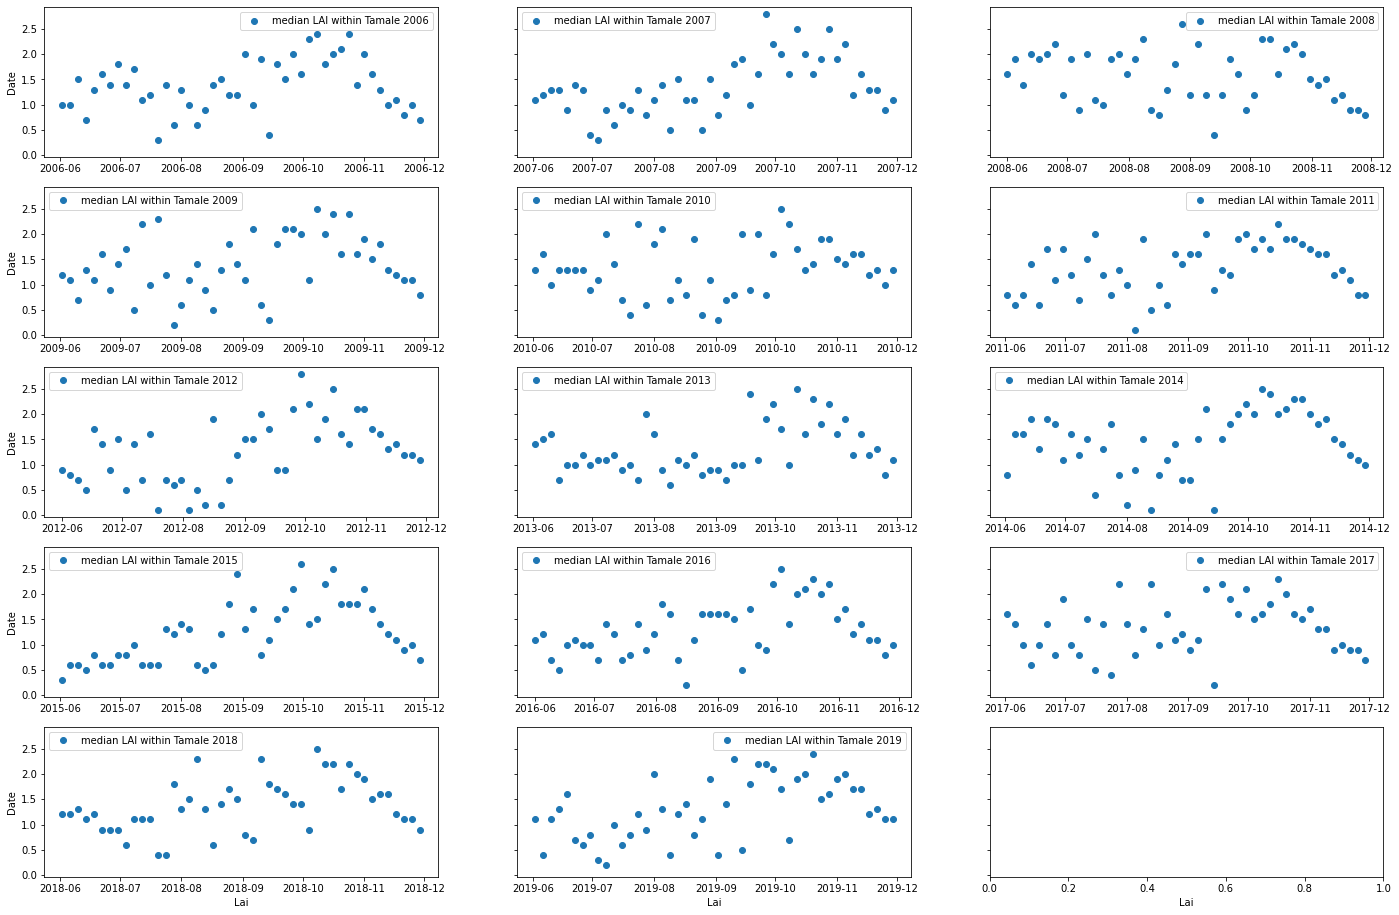

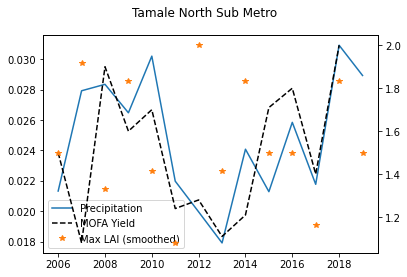

In [50]:
plot_district_ts(district = 'Tamale North Sub Metro')

File already exists? Yerp


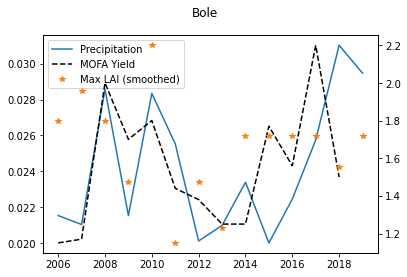

In [51]:
plot_district_ts(district = 'Bole')

MODIS Lai and mean both SUCCESS for 2006
MODIS LC_Type2 and mean both SUCCESS for 2006
MODIS Lai and mean both SUCCESS for 2007
MODIS LC_Type2 and mean both SUCCESS for 2007
MODIS Lai and mean both SUCCESS for 2008
MODIS LC_Type2 and mean both SUCCESS for 2008
MODIS Lai and mean both SUCCESS for 2009
MODIS LC_Type2 and mean both SUCCESS for 2009
MODIS Lai and mean both SUCCESS for 2010
MODIS LC_Type2 and mean both SUCCESS for 2010
MODIS Lai and mean both SUCCESS for 2011
MODIS LC_Type2 and mean both SUCCESS for 2011
MODIS Lai and mean both SUCCESS for 2012
MODIS LC_Type2 and mean both SUCCESS for 2012
MODIS Lai and mean both SUCCESS for 2013
MODIS LC_Type2 and mean both SUCCESS for 2013
MODIS Lai and mean both SUCCESS for 2014
MODIS LC_Type2 and mean both SUCCESS for 2014
MODIS Lai and mean both SUCCESS for 2015
MODIS LC_Type2 and mean both SUCCESS for 2015
MODIS Lai and mean both SUCCESS for 2016
MODIS LC_Type2 and mean both SUCCESS for 2016
MODIS Lai and mean both SUCCESS for 2017
MO

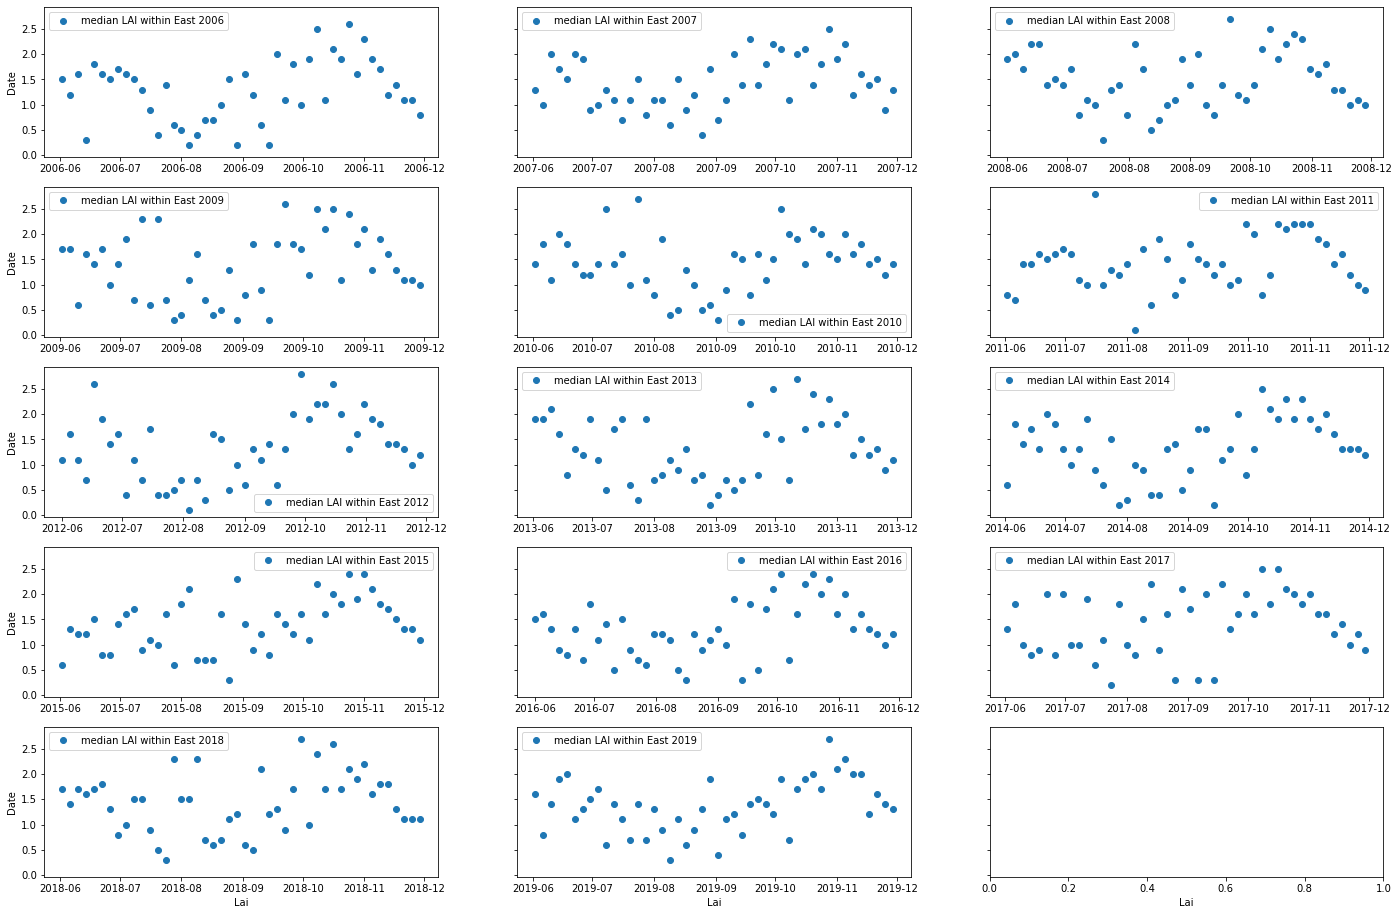

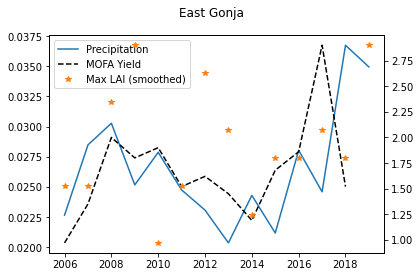

In [52]:
plot_district_ts(district = 'East Gonja')

MODIS Lai and mean both SUCCESS for 2006
MODIS LC_Type2 and mean both SUCCESS for 2006
MODIS Lai and mean both SUCCESS for 2007
MODIS LC_Type2 and mean both SUCCESS for 2007
MODIS Lai and mean both SUCCESS for 2008
MODIS LC_Type2 and mean both SUCCESS for 2008
MODIS Lai and mean both SUCCESS for 2009
MODIS LC_Type2 and mean both SUCCESS for 2009
MODIS Lai and mean both SUCCESS for 2010
MODIS LC_Type2 and mean both SUCCESS for 2010
MODIS Lai and mean both SUCCESS for 2011
MODIS LC_Type2 and mean both SUCCESS for 2011
MODIS Lai and mean both SUCCESS for 2012
MODIS LC_Type2 and mean both SUCCESS for 2012
MODIS Lai and mean both SUCCESS for 2013
MODIS LC_Type2 and mean both SUCCESS for 2013
MODIS Lai and mean both SUCCESS for 2014
MODIS LC_Type2 and mean both SUCCESS for 2014
MODIS Lai and mean both SUCCESS for 2015
MODIS LC_Type2 and mean both SUCCESS for 2015
MODIS Lai and mean both SUCCESS for 2016
MODIS LC_Type2 and mean both SUCCESS for 2016
MODIS Lai and mean both SUCCESS for 2017
MO

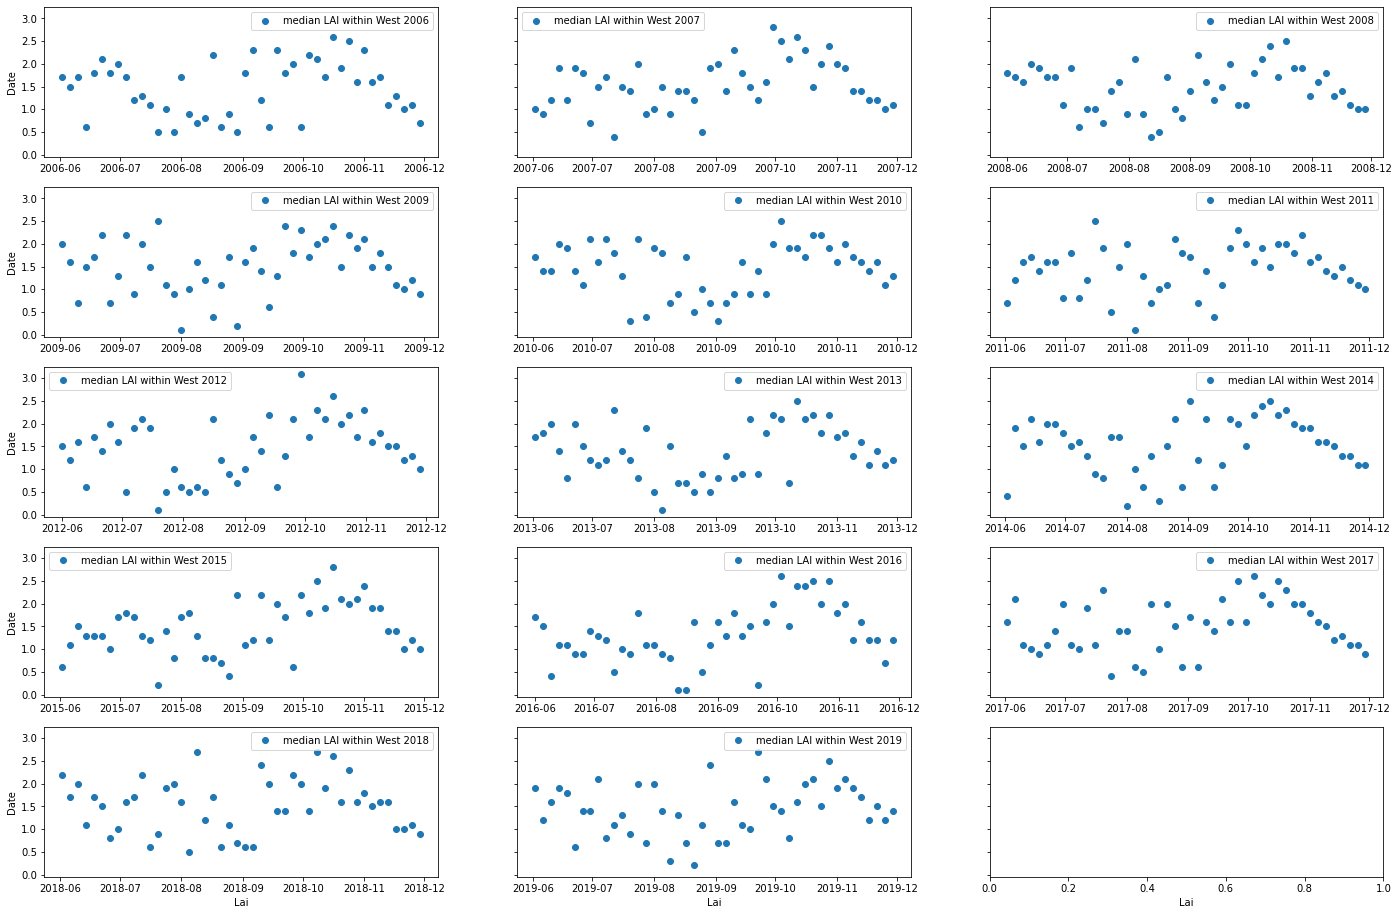

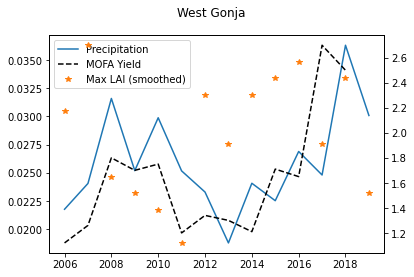

In [53]:
plot_district_ts(district = 'West Gonja')

MODIS Lai and mean both SUCCESS for 2006
MODIS LC_Type2 and mean both SUCCESS for 2006
MODIS Lai and mean both SUCCESS for 2007
MODIS LC_Type2 and mean both SUCCESS for 2007
MODIS Lai and mean both SUCCESS for 2008
MODIS LC_Type2 and mean both SUCCESS for 2008
MODIS Lai and mean both SUCCESS for 2009
MODIS LC_Type2 and mean both SUCCESS for 2009
MODIS Lai and mean both SUCCESS for 2010
MODIS LC_Type2 and mean both SUCCESS for 2010
MODIS Lai and mean both SUCCESS for 2011
MODIS LC_Type2 and mean both SUCCESS for 2011
MODIS Lai and mean both SUCCESS for 2012
MODIS LC_Type2 and mean both SUCCESS for 2012
MODIS Lai and mean both SUCCESS for 2013
MODIS LC_Type2 and mean both SUCCESS for 2013
MODIS Lai and mean both SUCCESS for 2014
MODIS LC_Type2 and mean both SUCCESS for 2014
MODIS Lai and mean both SUCCESS for 2015
MODIS LC_Type2 and mean both SUCCESS for 2015
MODIS Lai and mean both SUCCESS for 2016
MODIS LC_Type2 and mean both SUCCESS for 2016
MODIS Lai and mean both SUCCESS for 2017
MO

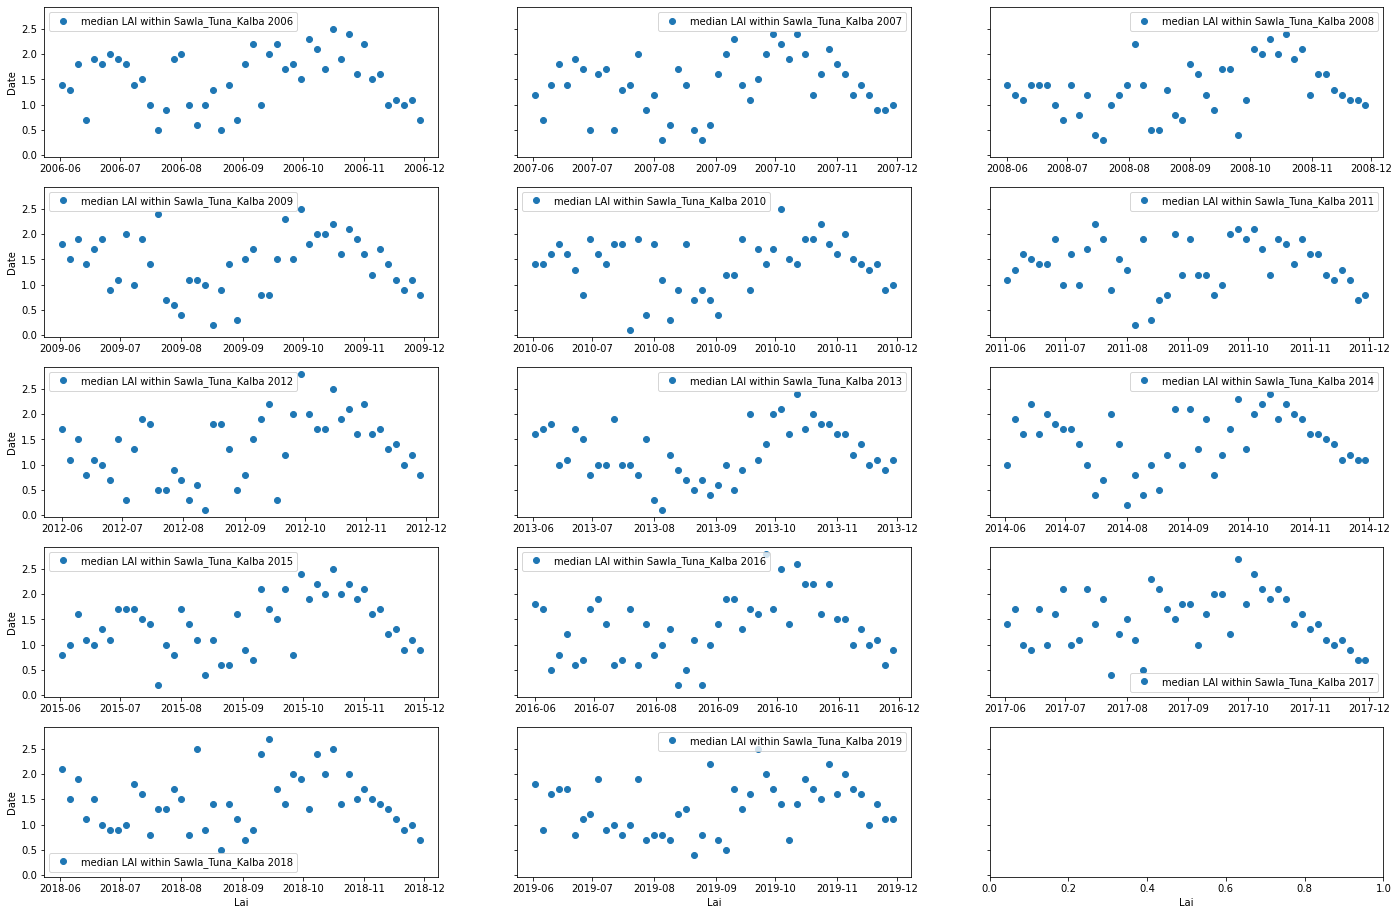

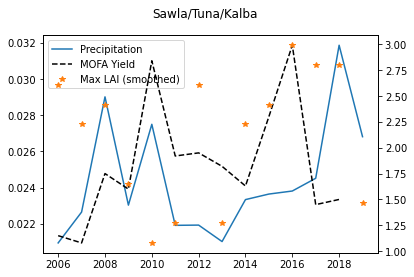

In [62]:
plot_district_ts(district = 'Sawla/Tuna/Kalba')

File already exists? Yerp


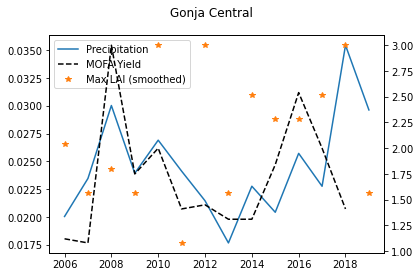

In [73]:
plot_district_ts(district = 'Gonja Central')

File already exists? Yerp


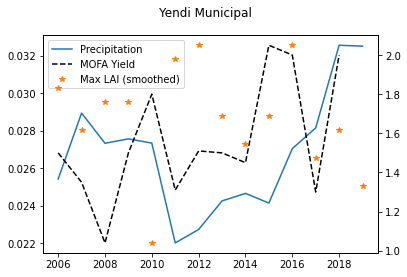

In [72]:
plot_district_ts(district = 'Yendi Municipal')

Gonja Central
Qtrend_GonjaCentral.png exists already.
Sawla/Tuna/Kalba
Qtrend_Sawla_Tuna_Kalba.png exists already.
Bunkpurugu Yonyo
MODIS Lai and mean both SUCCESS for 2006
MODIS LC_Type2 and mean both SUCCESS for 2006
MODIS Lai and mean both SUCCESS for 2007
MODIS LC_Type2 and mean both SUCCESS for 2007
MODIS Lai and mean both SUCCESS for 2008
MODIS LC_Type2 and mean both SUCCESS for 2008
MODIS Lai and mean both SUCCESS for 2009
MODIS LC_Type2 and mean both SUCCESS for 2009
MODIS Lai and mean both SUCCESS for 2010
MODIS LC_Type2 and mean both SUCCESS for 2010
MODIS Lai and mean both SUCCESS for 2011
MODIS LC_Type2 and mean both SUCCESS for 2011
MODIS Lai and mean both SUCCESS for 2012
MODIS LC_Type2 and mean both SUCCESS for 2012
MODIS Lai and mean both SUCCESS for 2013
MODIS LC_Type2 and mean both SUCCESS for 2013
MODIS Lai and mean both SUCCESS for 2014
MODIS LC_Type2 and mean both SUCCESS for 2014
MODIS Lai and mean both SUCCESS for 2015
MODIS LC_Type2 and mean both SUCCESS for 201

MODIS LC_Type2 and mean both SUCCESS for 2013
MODIS Lai and mean both SUCCESS for 2014
MODIS LC_Type2 and mean both SUCCESS for 2014
MODIS Lai and mean both SUCCESS for 2015
MODIS LC_Type2 and mean both SUCCESS for 2015
MODIS Lai and mean both SUCCESS for 2016
MODIS LC_Type2 and mean both SUCCESS for 2016
MODIS Lai and mean both SUCCESS for 2017
MODIS LC_Type2 and mean both SUCCESS for 2017
MODIS Lai and mean both SUCCESS for 2018
MODIS LC_Type2 and mean both SUCCESS for 2018
MODIS Lai and mean both SUCCESS for 2019
MODIS LC_Type2 and mean both SUCCESS for 2019
Kpandai
MODIS Lai and mean both SUCCESS for 2006
MODIS LC_Type2 and mean both SUCCESS for 2006
MODIS Lai and mean both SUCCESS for 2007
MODIS LC_Type2 and mean both SUCCESS for 2007
MODIS Lai and mean both SUCCESS for 2008
MODIS LC_Type2 and mean both SUCCESS for 2008
MODIS Lai and mean both SUCCESS for 2009
MODIS LC_Type2 and mean both SUCCESS for 2009
MODIS Lai and mean both SUCCESS for 2010
MODIS LC_Type2 and mean both SUCCES

/Users/qingling/opt/anaconda3/envs/gee/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


MODIS Lai and mean both SUCCESS for 2006
MODIS LC_Type2 and mean both SUCCESS for 2006
MODIS Lai and mean both SUCCESS for 2007
MODIS LC_Type2 and mean both SUCCESS for 2007
MODIS Lai and mean both SUCCESS for 2008
MODIS LC_Type2 and mean both SUCCESS for 2008
MODIS Lai and mean both SUCCESS for 2009
MODIS LC_Type2 and mean both SUCCESS for 2009
MODIS Lai and mean both SUCCESS for 2010
MODIS LC_Type2 and mean both SUCCESS for 2010
MODIS Lai and mean both SUCCESS for 2011
MODIS LC_Type2 and mean both SUCCESS for 2011
MODIS Lai and mean both SUCCESS for 2012
MODIS LC_Type2 and mean both SUCCESS for 2012
MODIS Lai and mean both SUCCESS for 2013
MODIS LC_Type2 and mean both SUCCESS for 2013
MODIS Lai and mean both SUCCESS for 2014
MODIS LC_Type2 and mean both SUCCESS for 2014
MODIS Lai and mean both SUCCESS for 2015
MODIS LC_Type2 and mean both SUCCESS for 2015
MODIS Lai and mean both SUCCESS for 2016
MODIS LC_Type2 and mean both SUCCESS for 2016
MODIS Lai and mean both SUCCESS for 2017
MO

MODIS LC_Type2 and mean both SUCCESS for 2015
MODIS Lai and mean both SUCCESS for 2016
MODIS LC_Type2 and mean both SUCCESS for 2016
MODIS Lai and mean both SUCCESS for 2017
MODIS LC_Type2 and mean both SUCCESS for 2017
MODIS Lai and mean both SUCCESS for 2018
MODIS LC_Type2 and mean both SUCCESS for 2018
MODIS Lai and mean both SUCCESS for 2019
MODIS LC_Type2 and mean both SUCCESS for 2019
Tatale
MODIS Lai and mean both SUCCESS for 2006
MODIS LC_Type2 and mean both SUCCESS for 2006
MODIS Lai and mean both SUCCESS for 2007
MODIS LC_Type2 and mean both SUCCESS for 2007
MODIS Lai and mean both SUCCESS for 2008
MODIS LC_Type2 and mean both SUCCESS for 2008
MODIS Lai and mean both SUCCESS for 2009
MODIS LC_Type2 and mean both SUCCESS for 2009
MODIS Lai and mean both SUCCESS for 2010
MODIS LC_Type2 and mean both SUCCESS for 2010
MODIS Lai and mean both SUCCESS for 2011
MODIS LC_Type2 and mean both SUCCESS for 2011
MODIS Lai and mean both SUCCESS for 2012
MODIS LC_Type2 and mean both SUCCESS

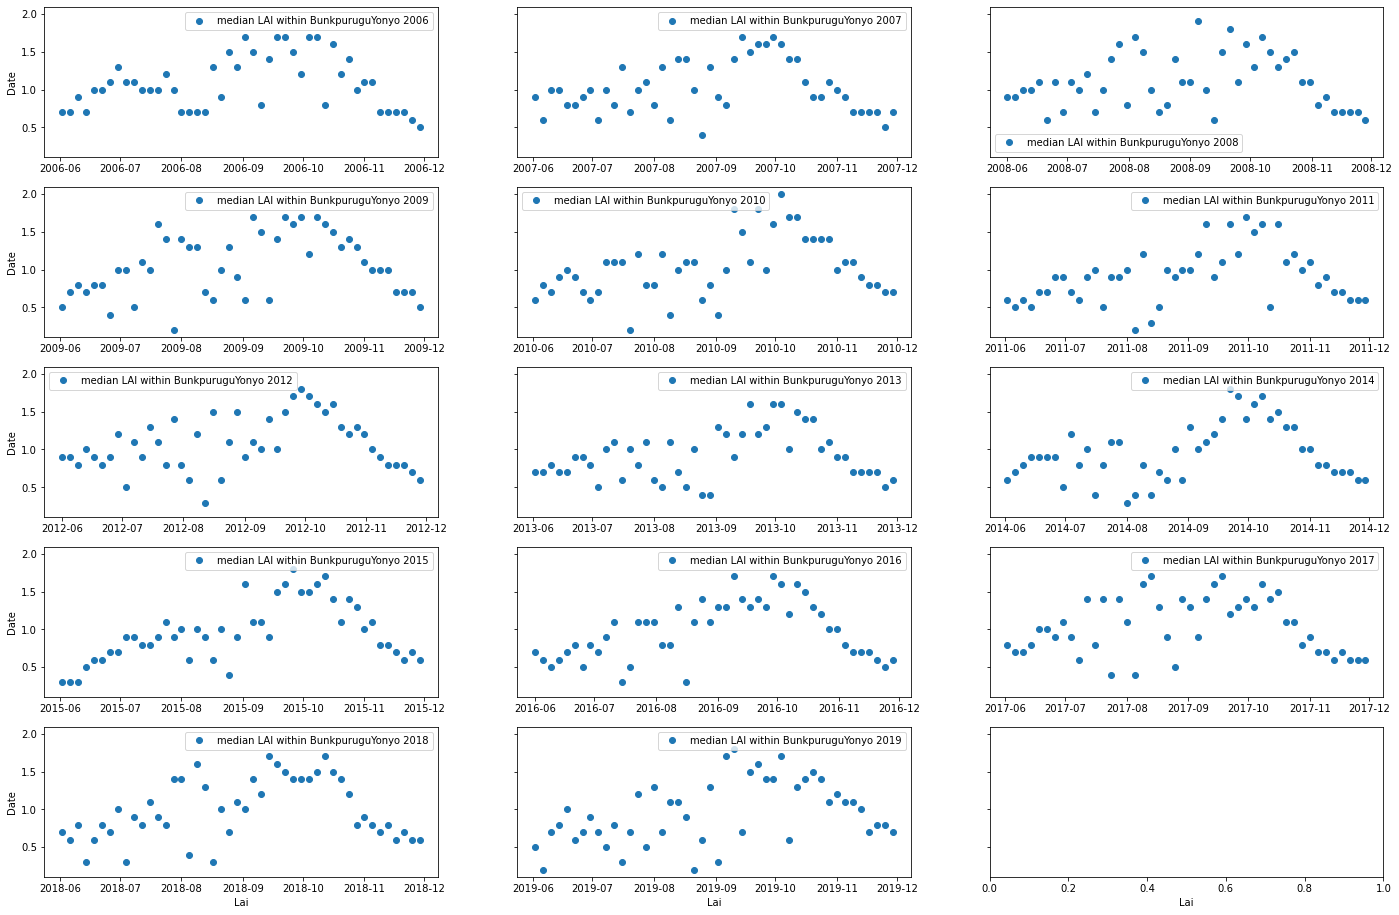

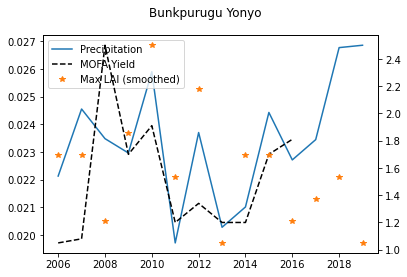

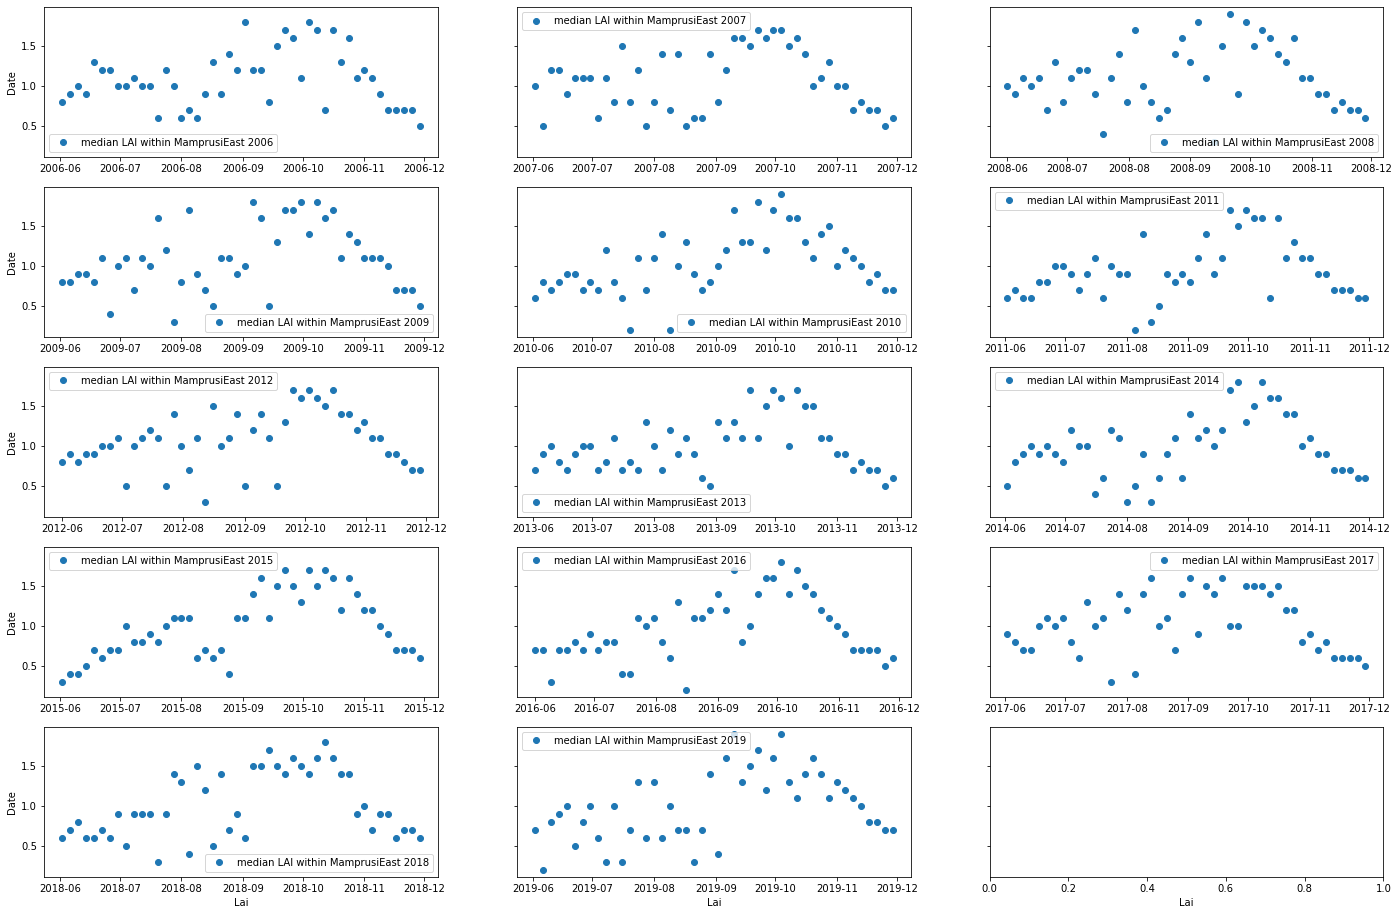

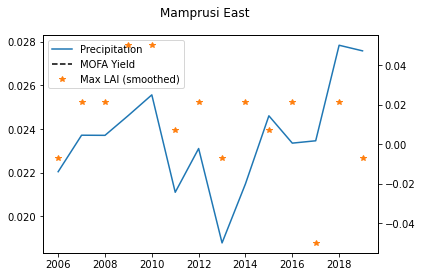

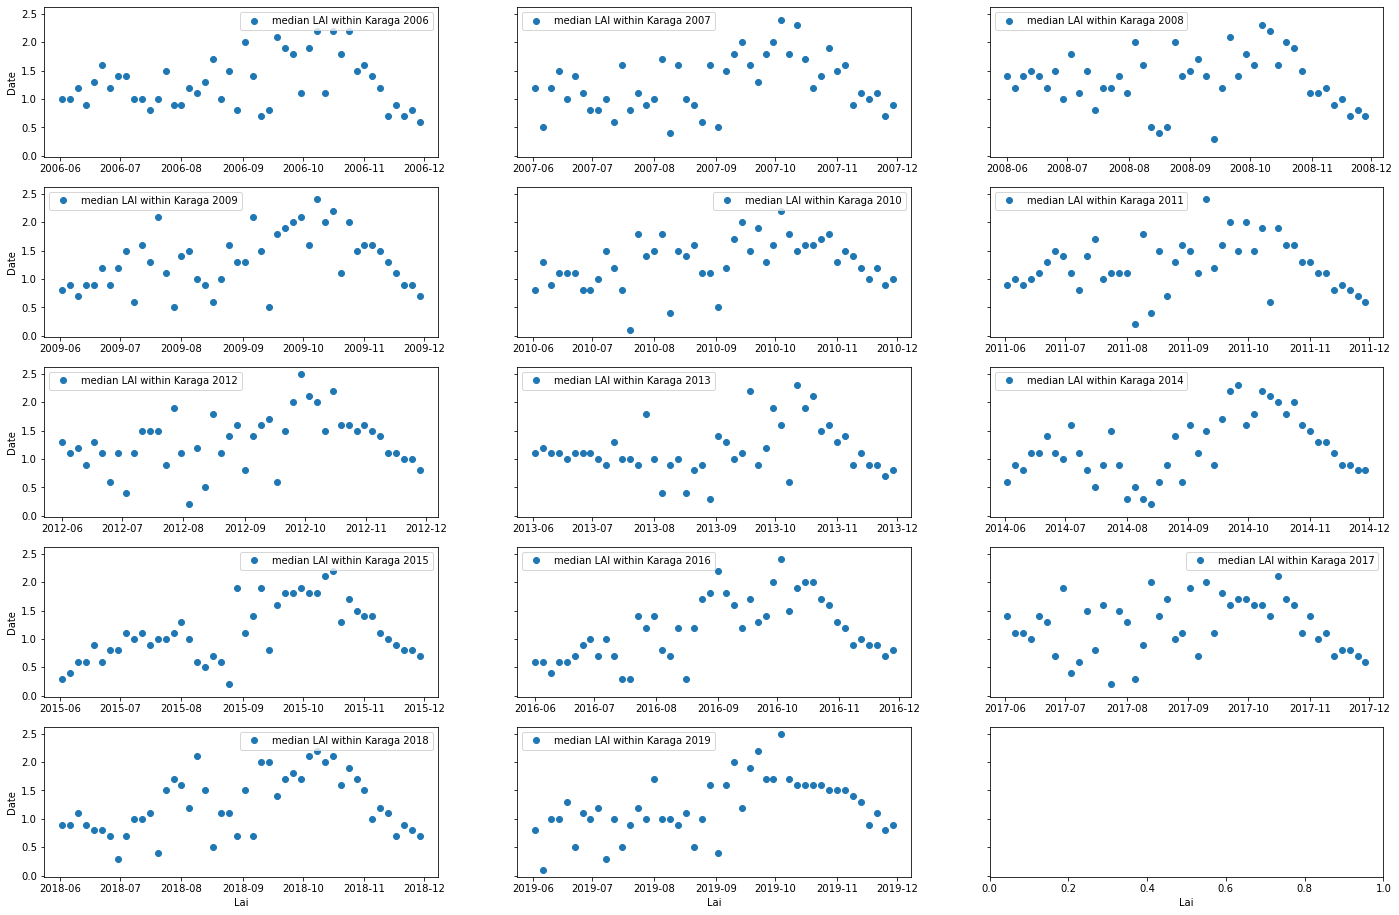

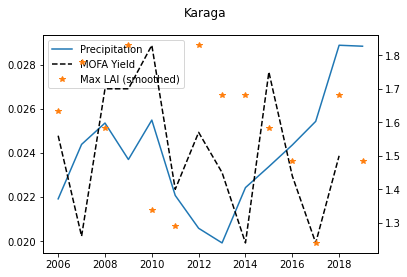

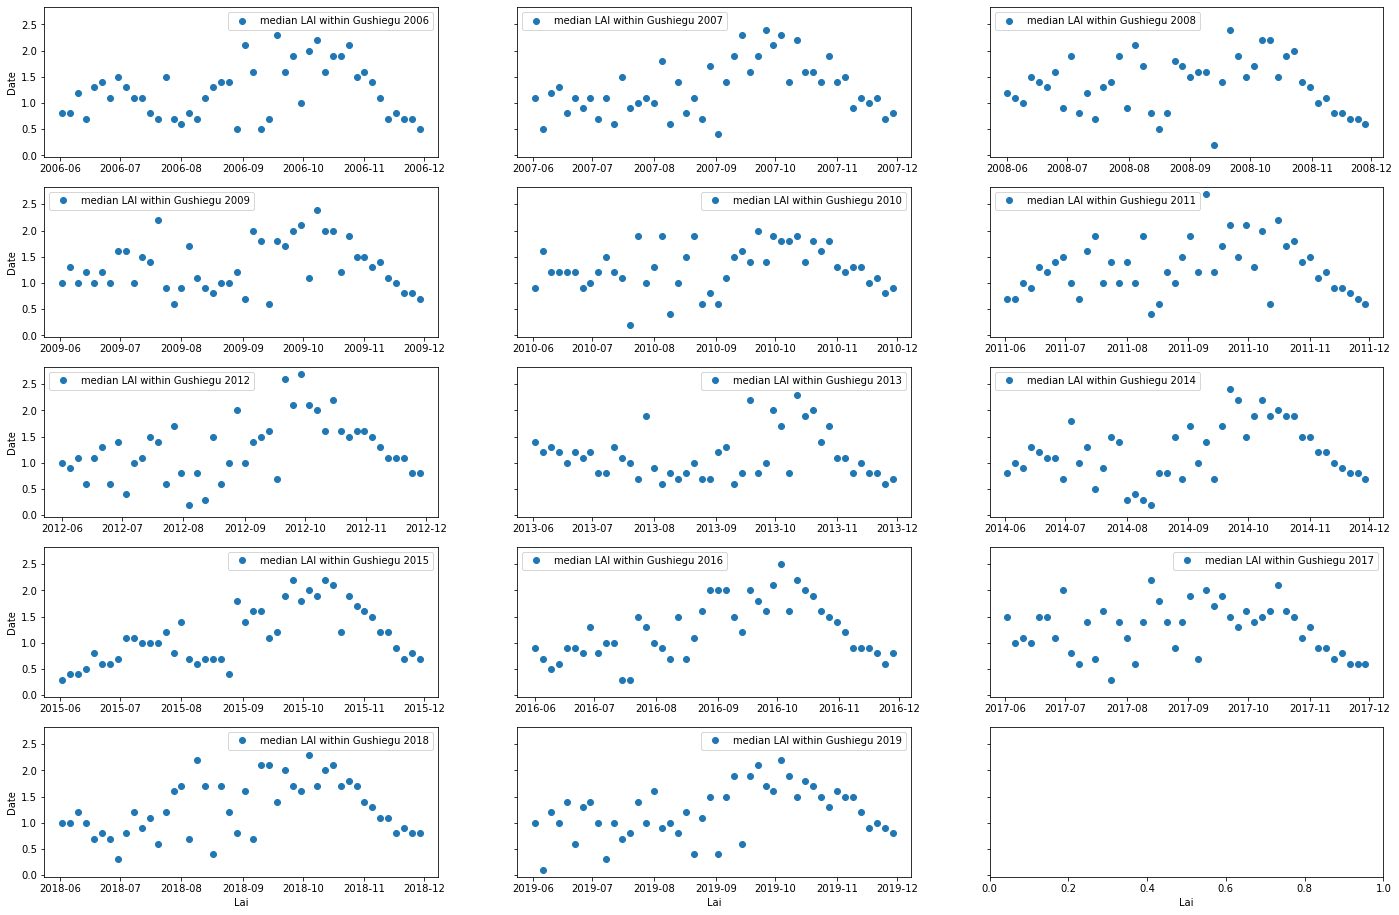

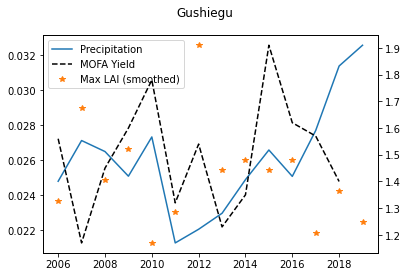

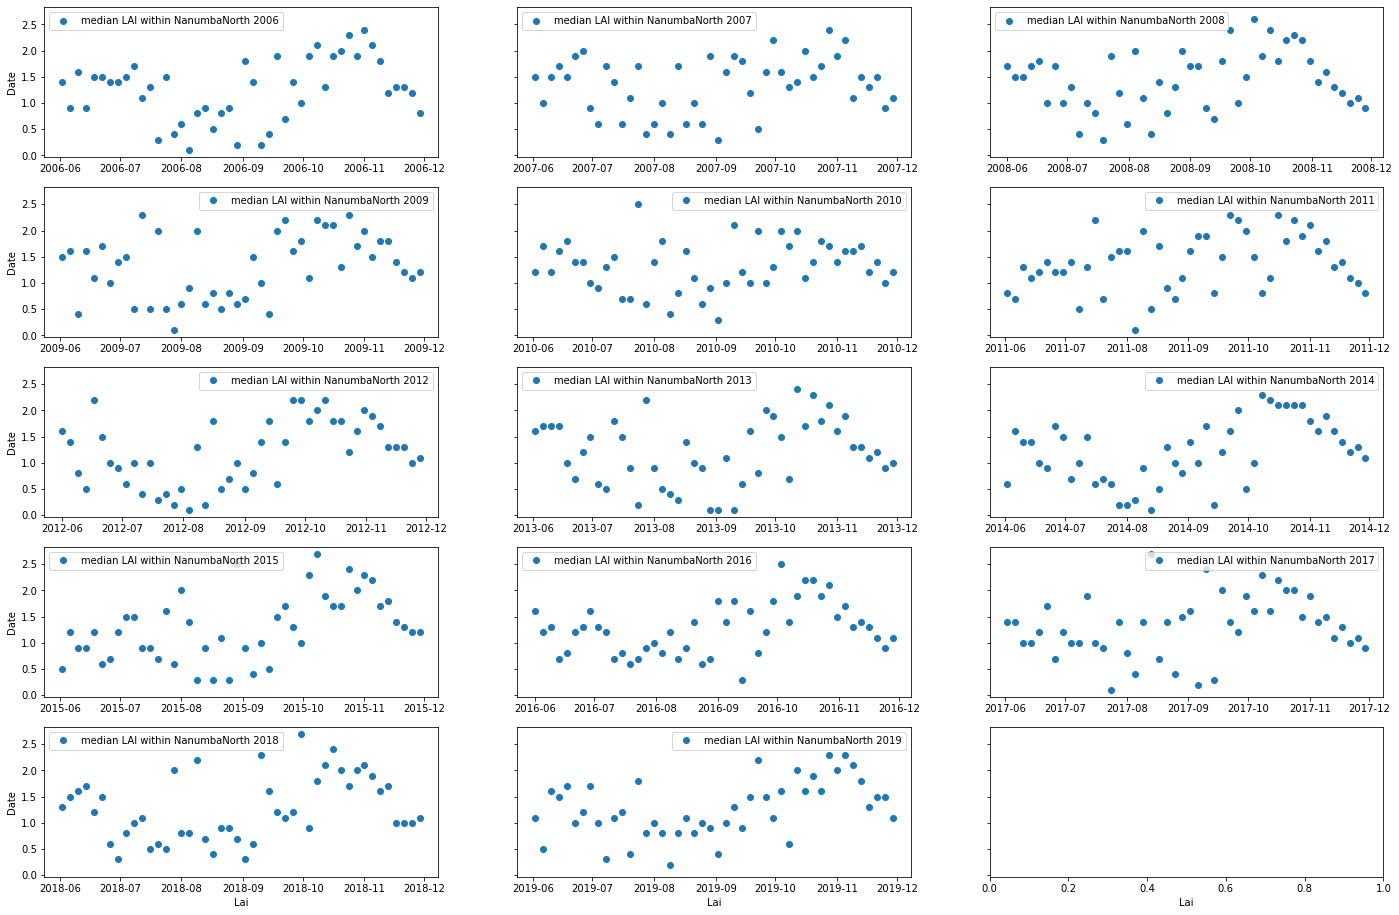

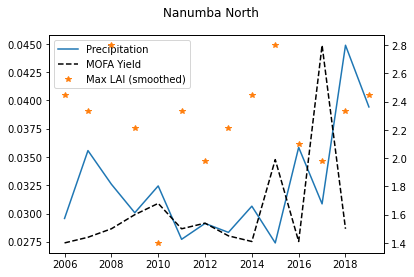

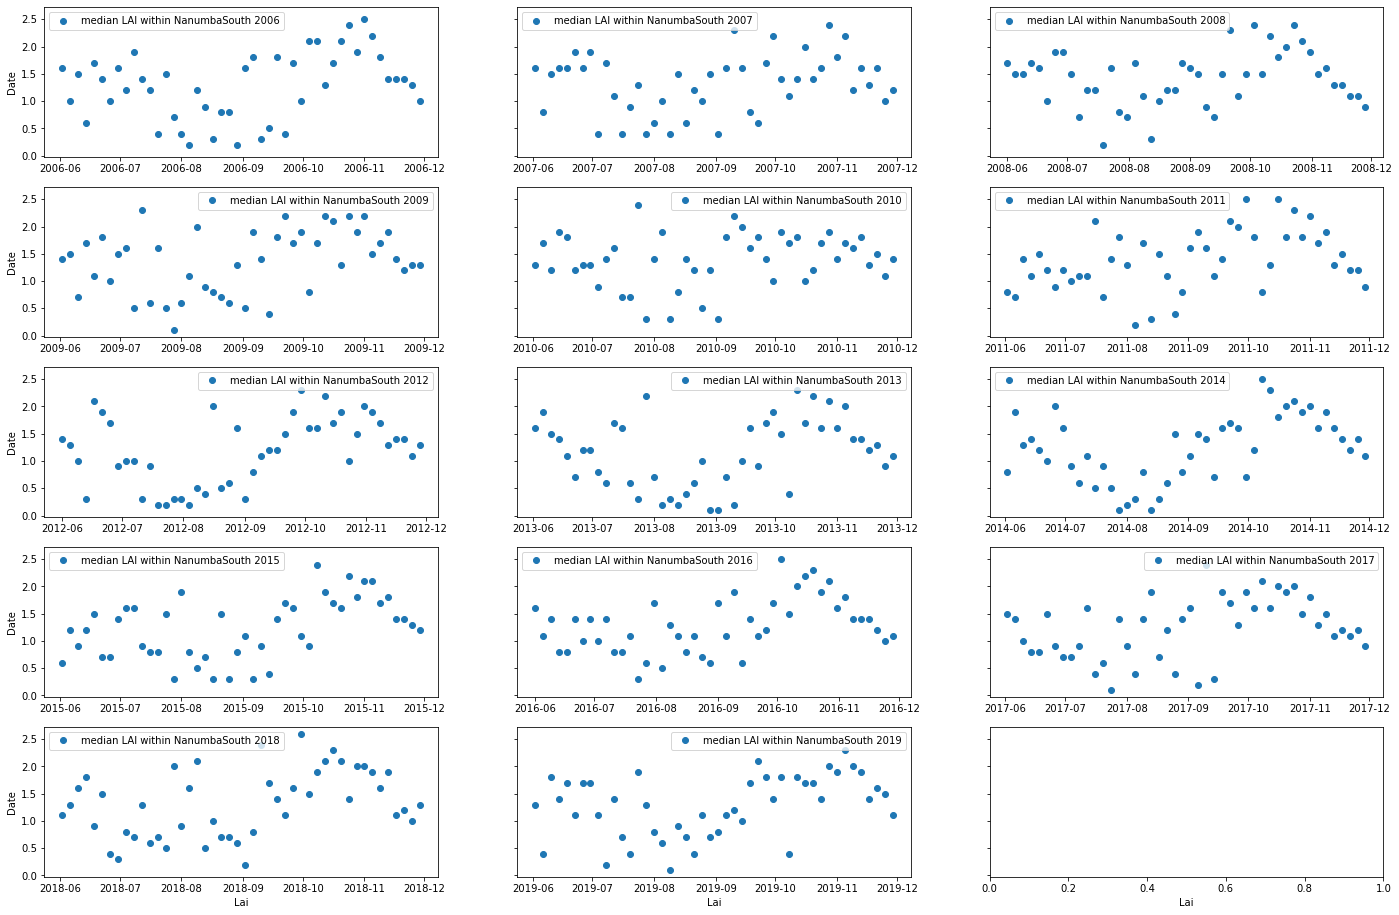

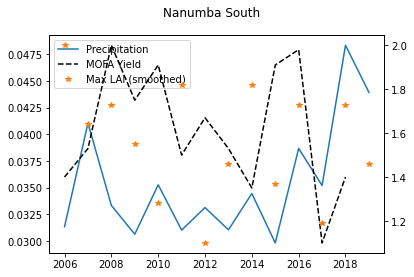

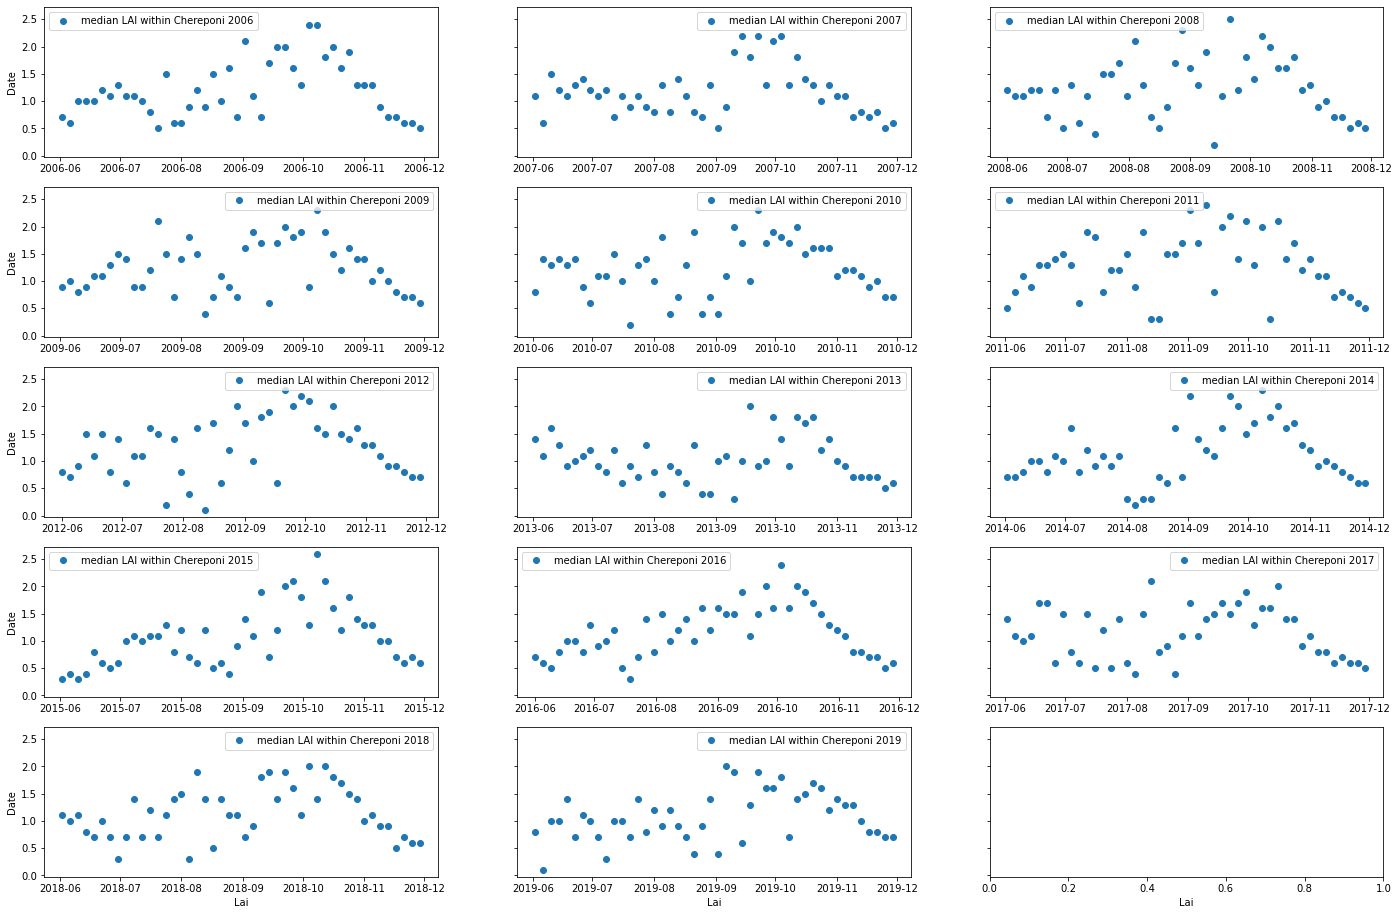

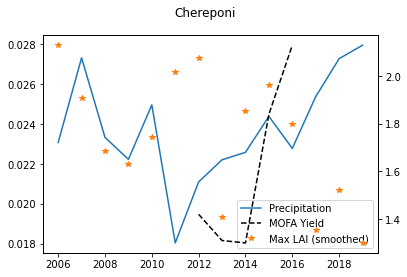

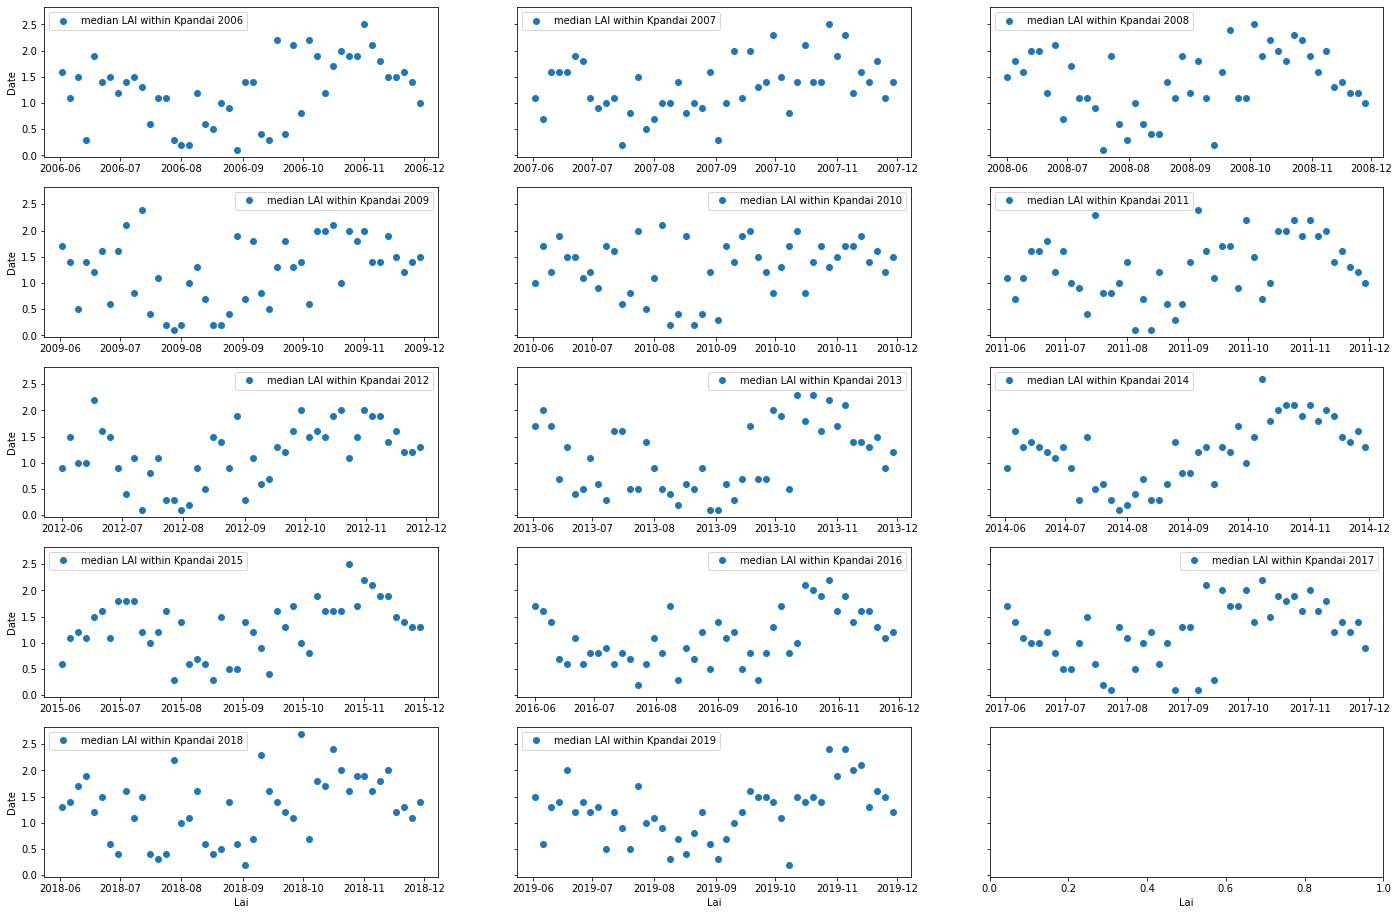

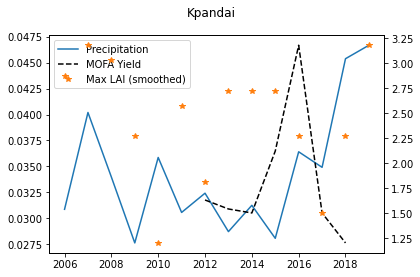

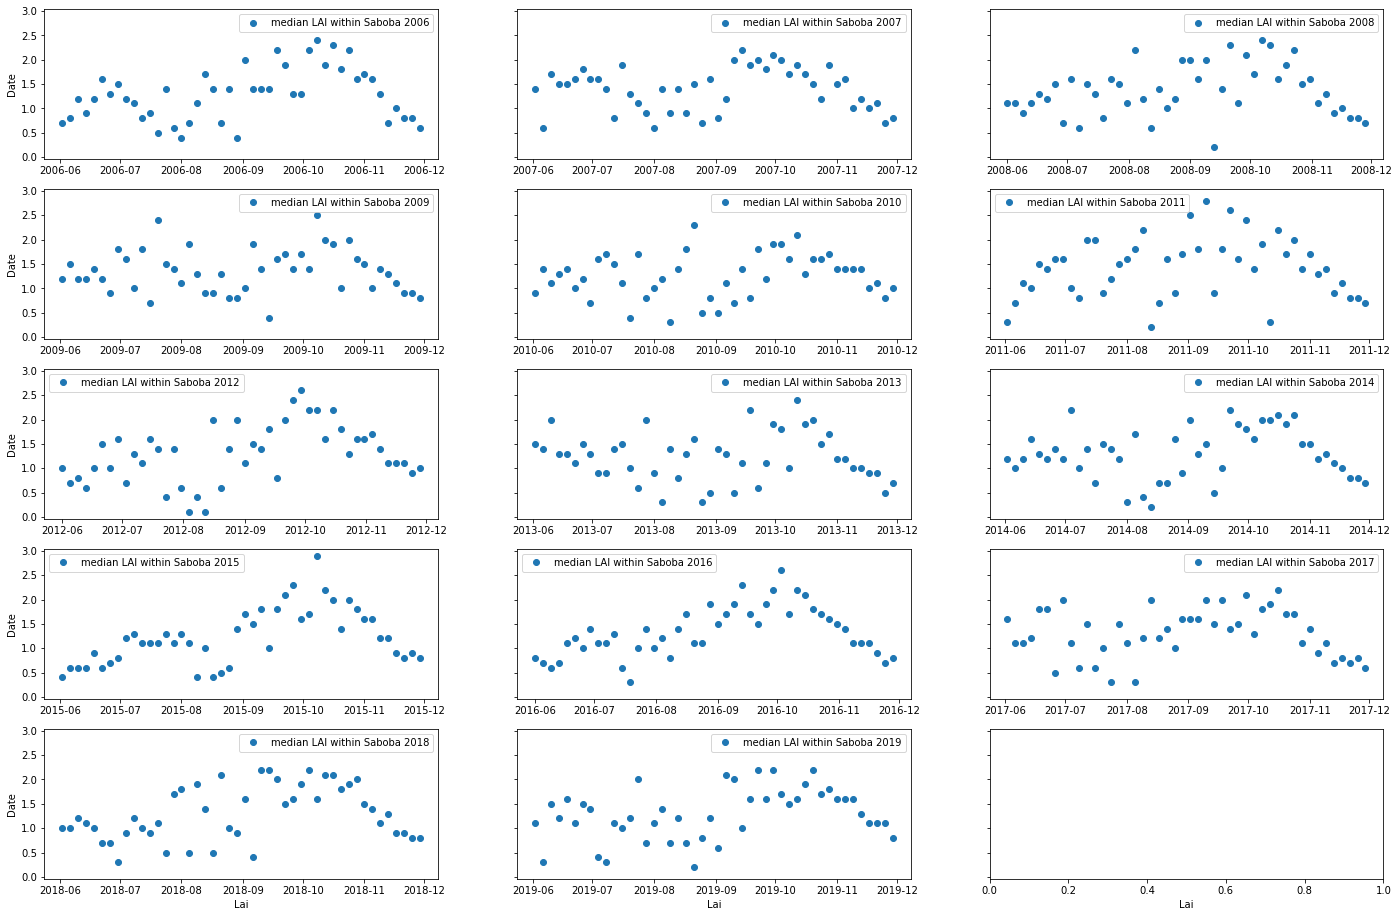

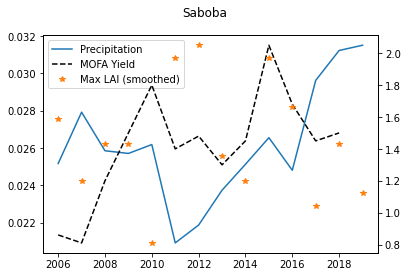

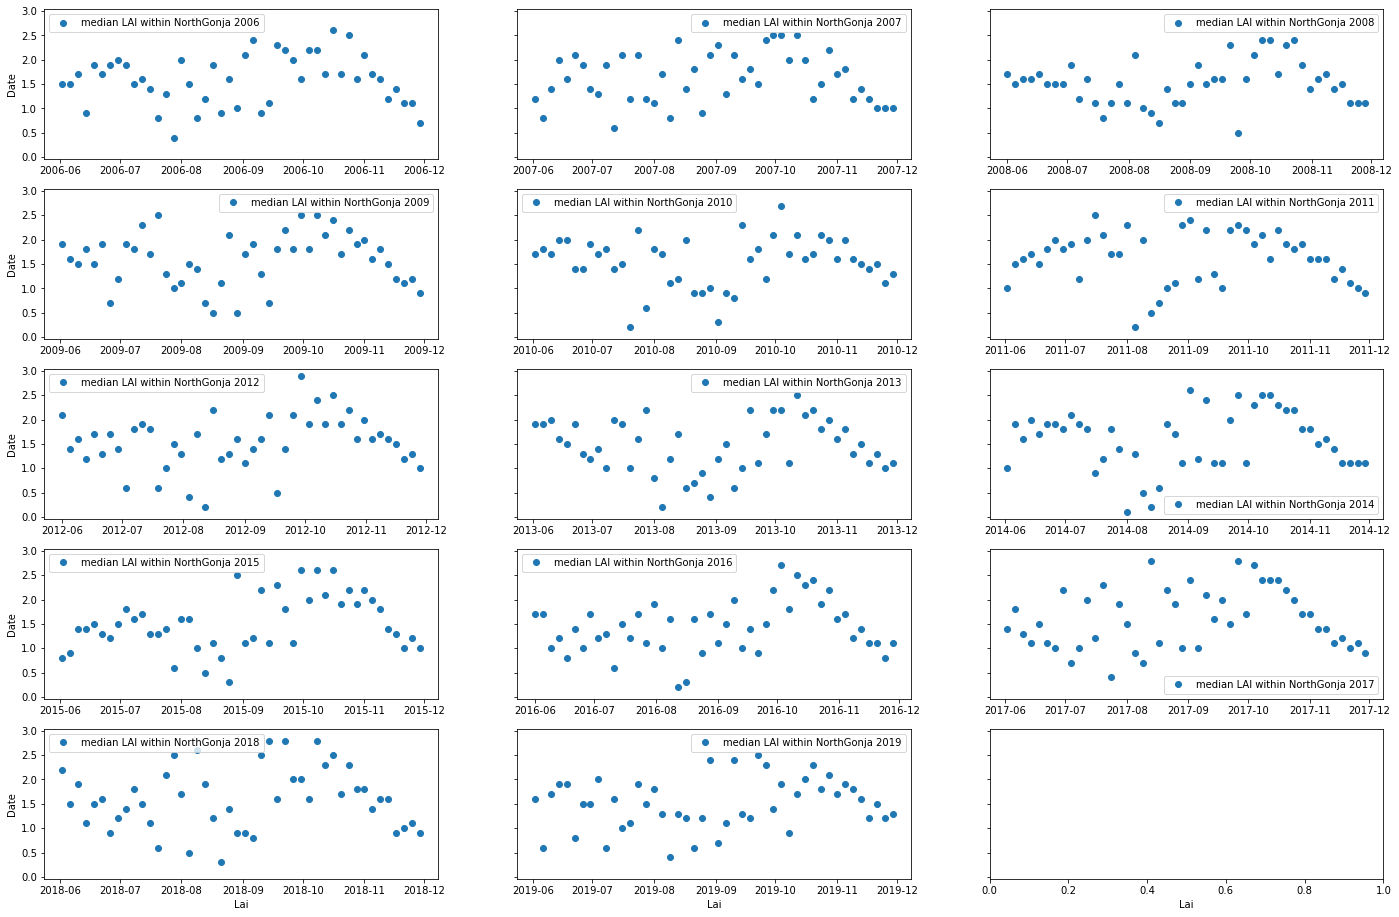

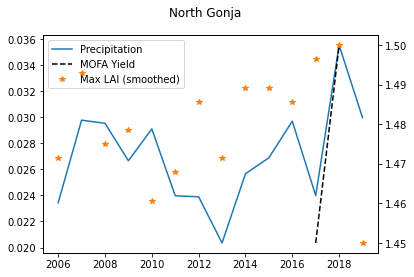

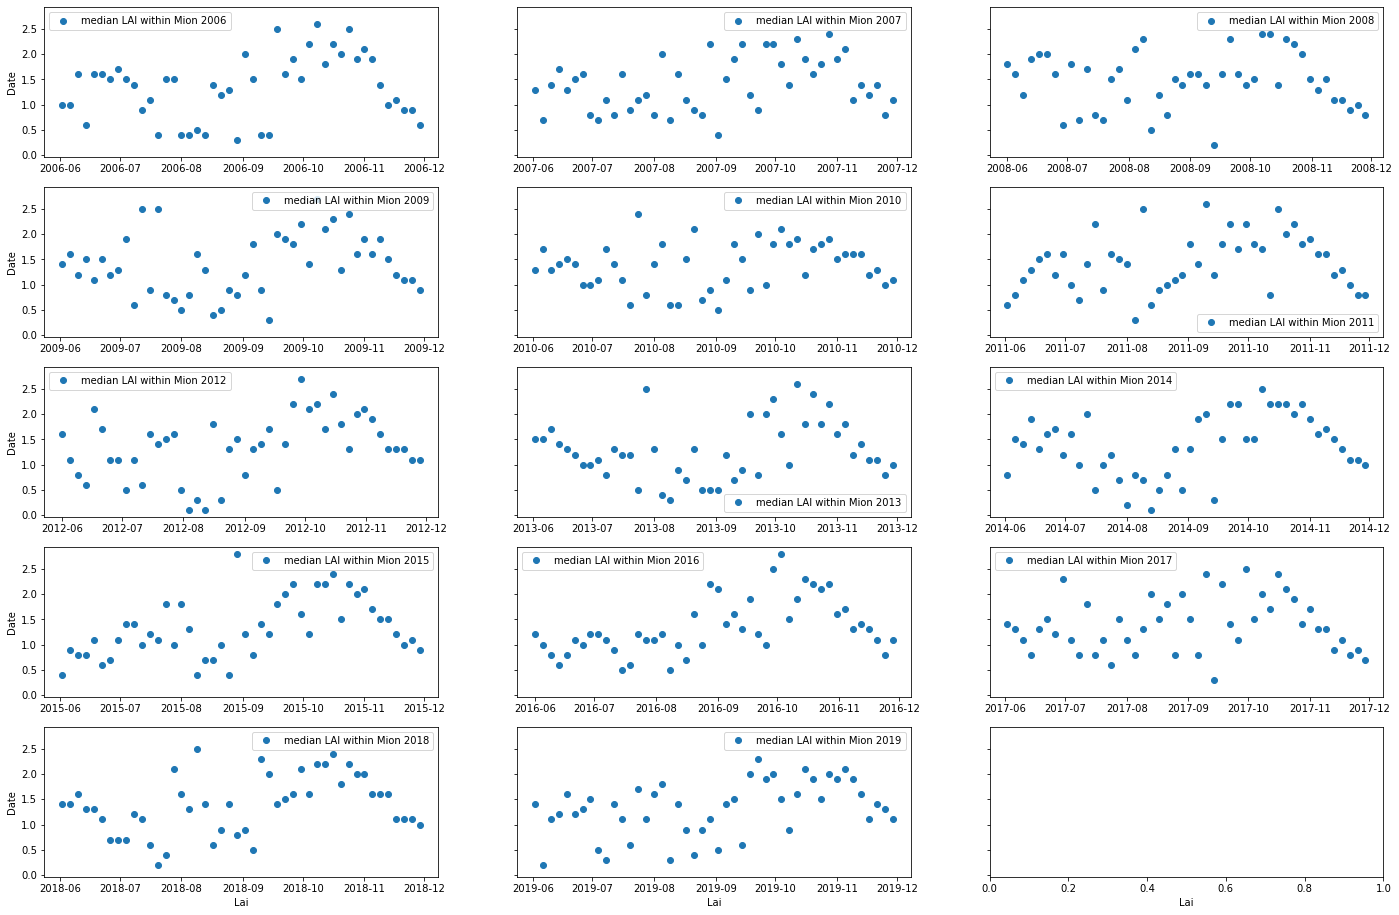

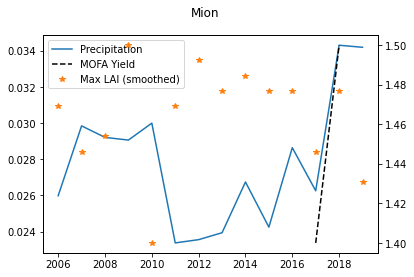

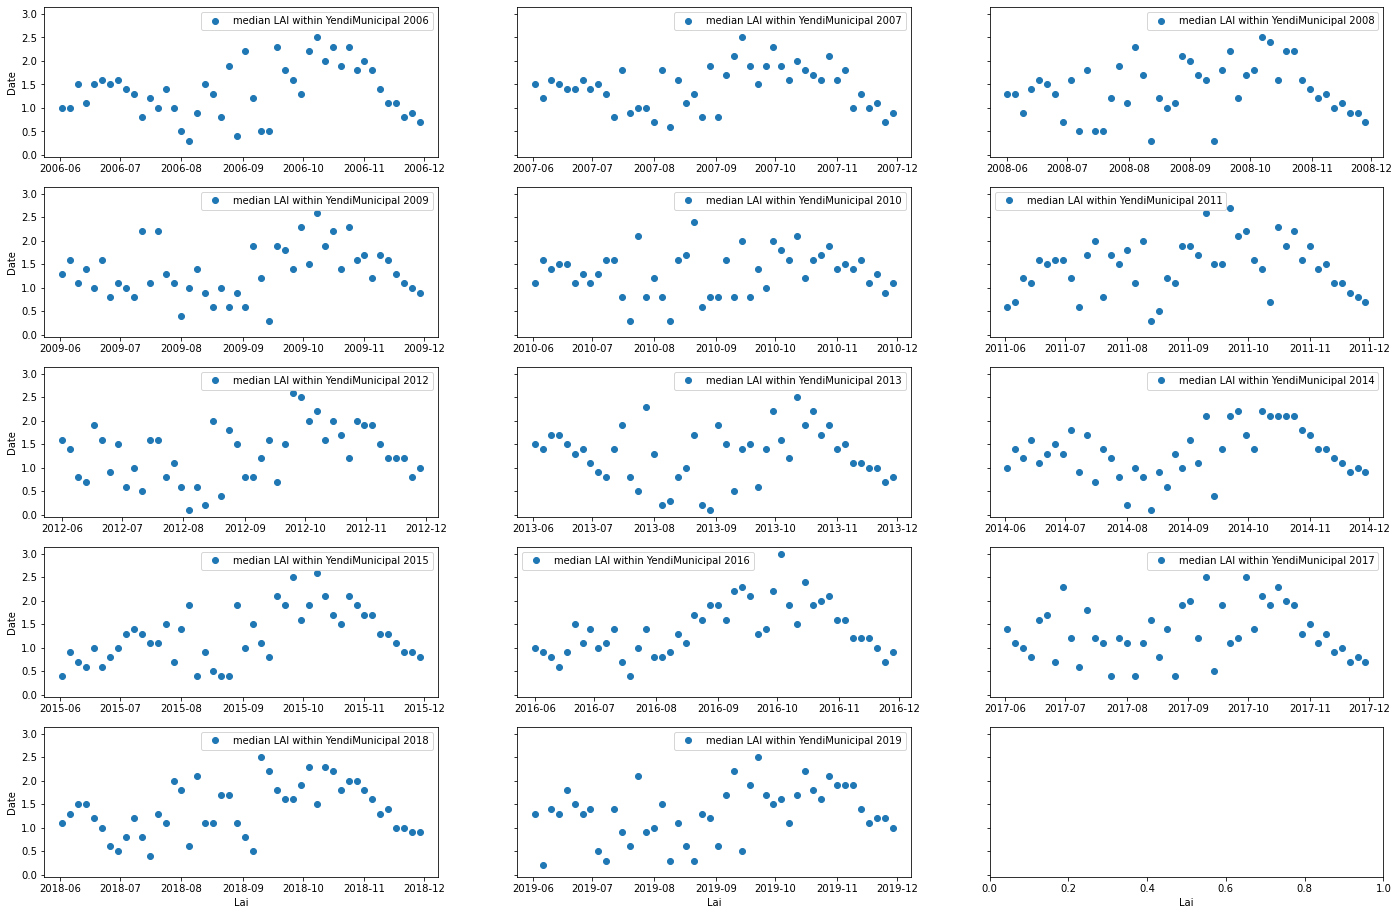

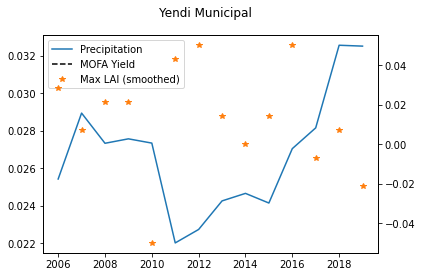

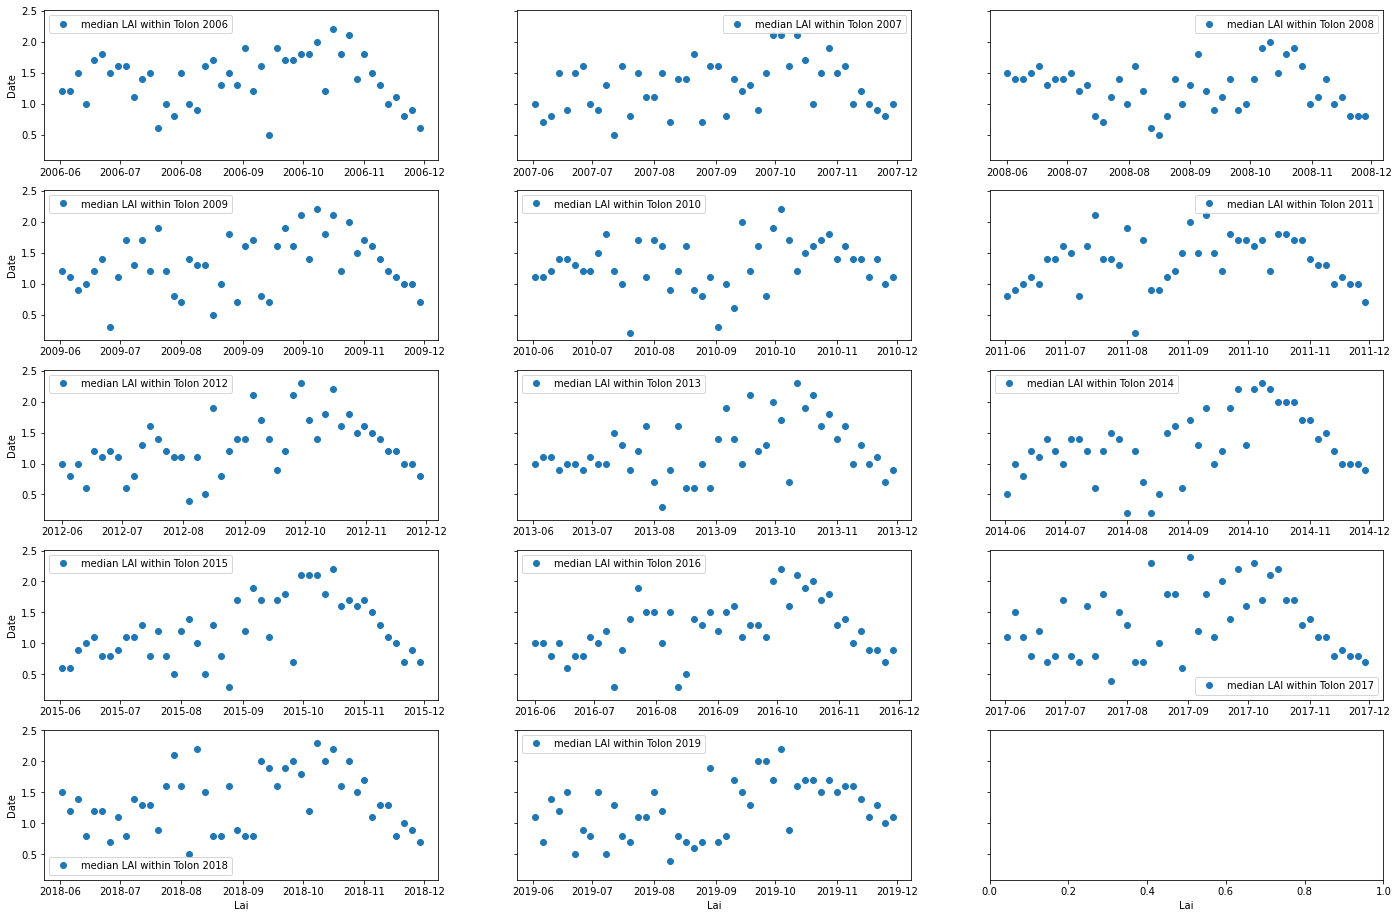

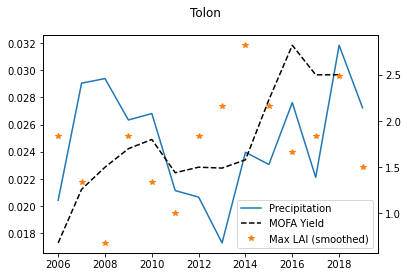

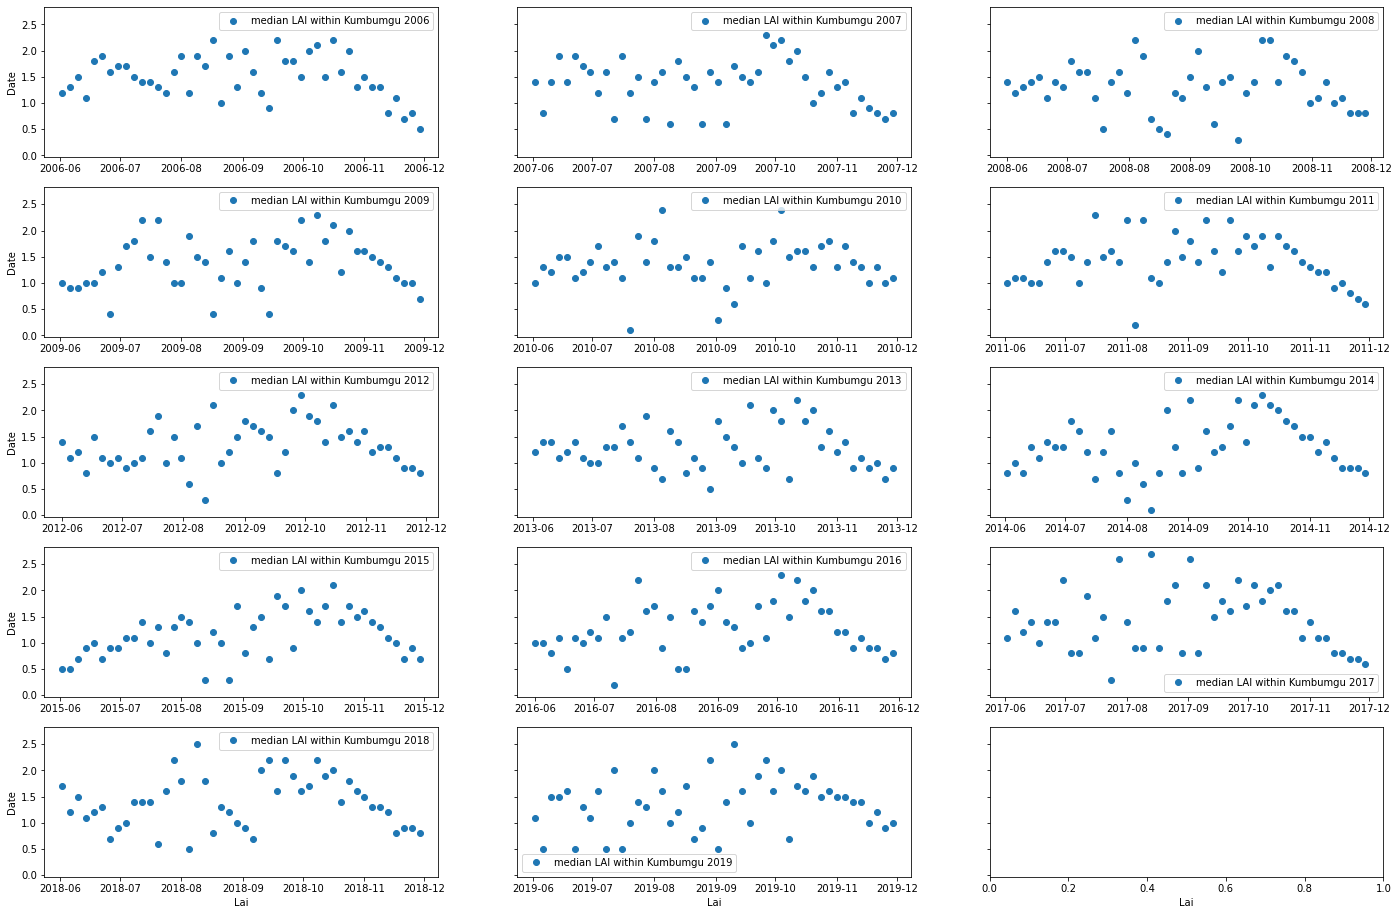

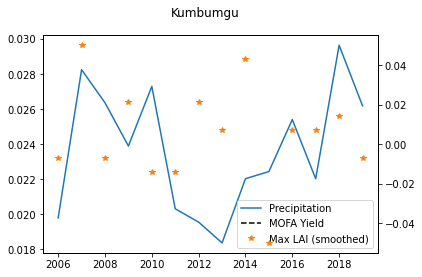

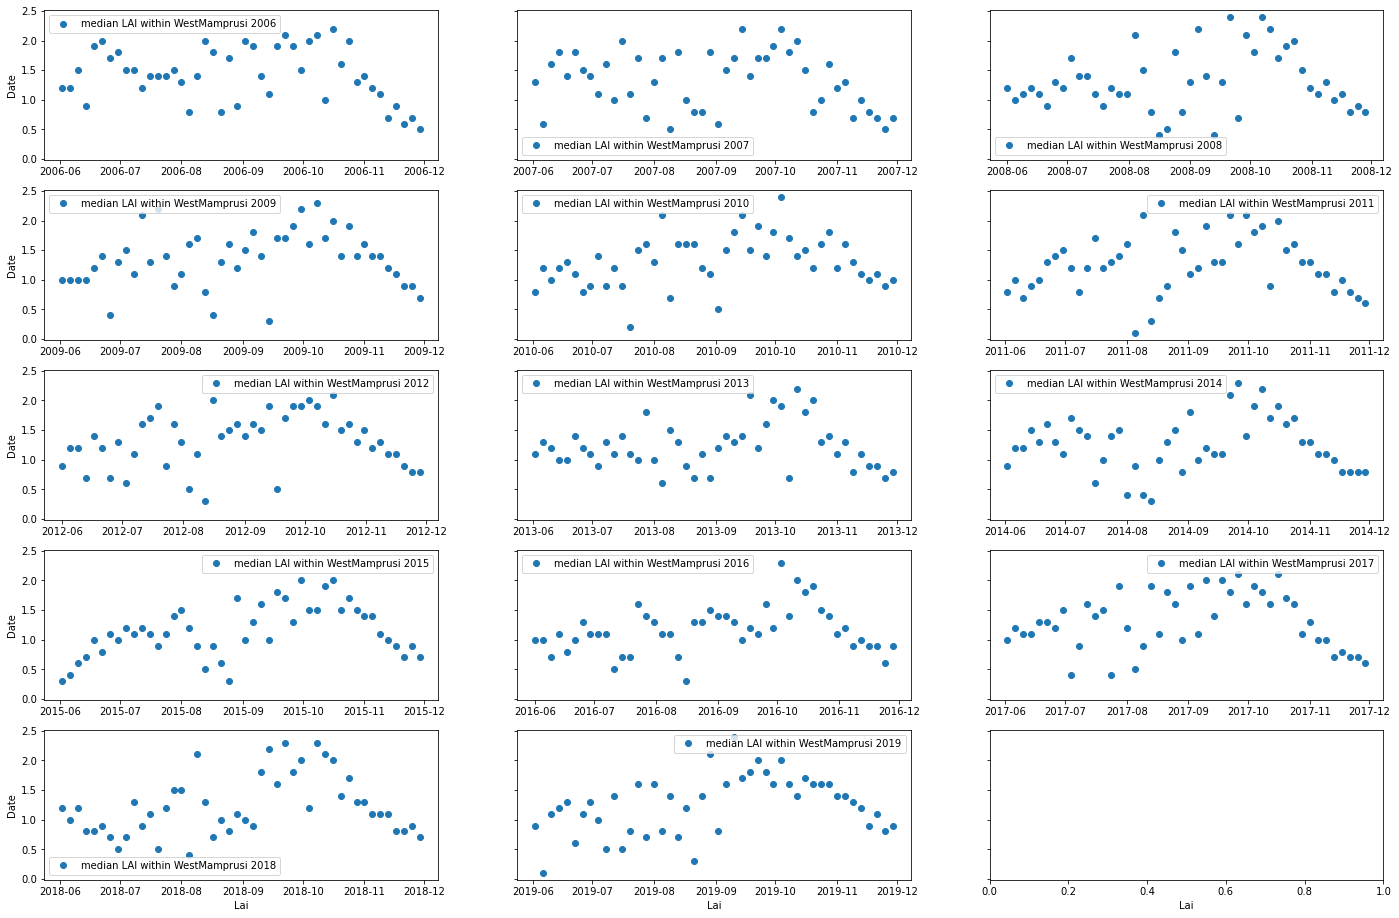

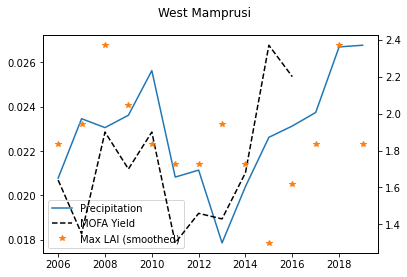

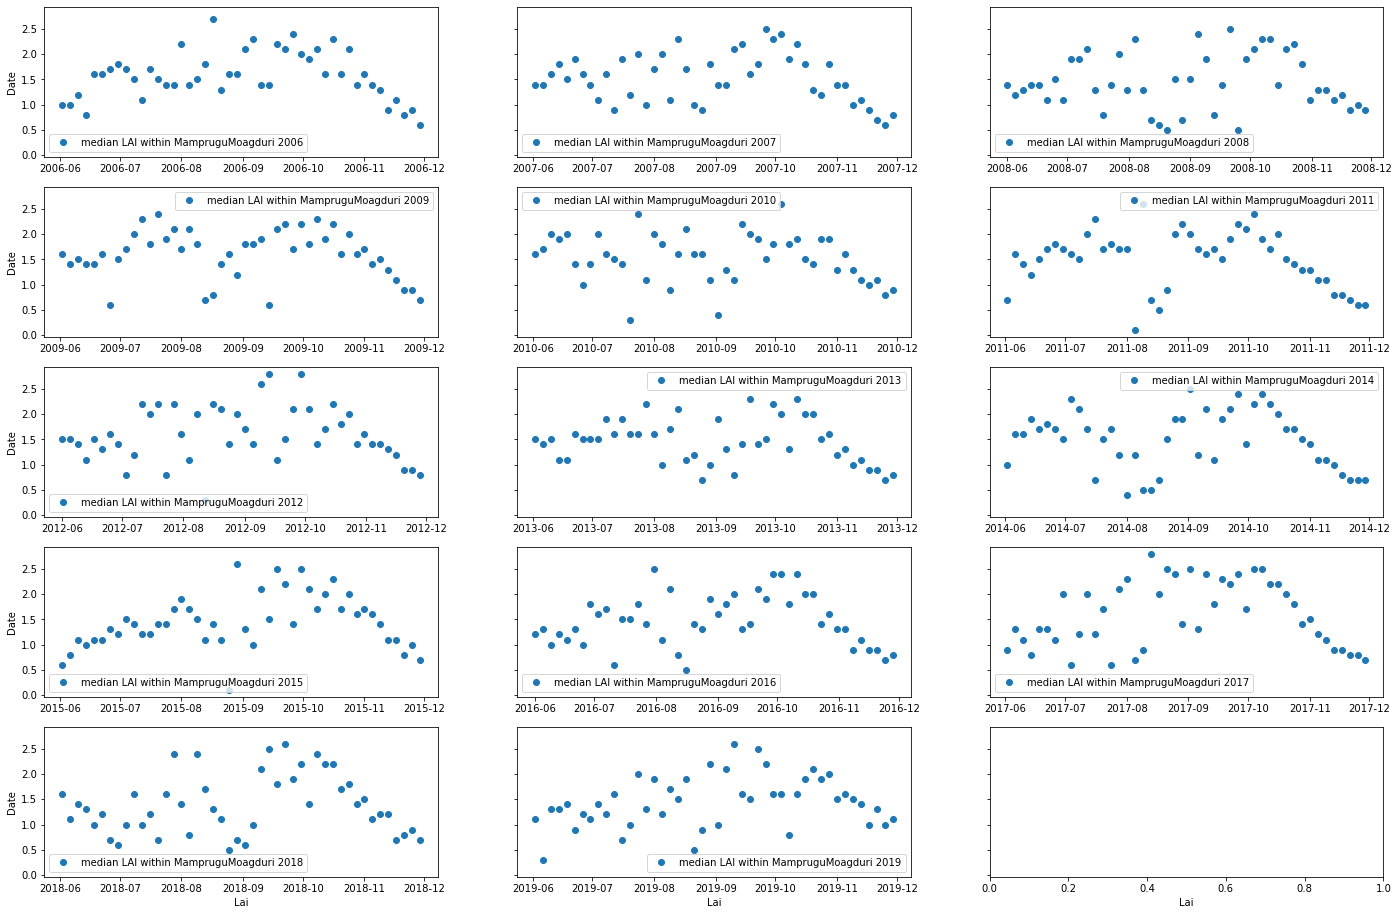

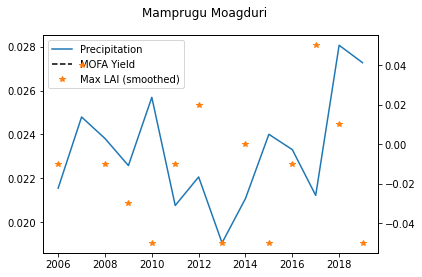

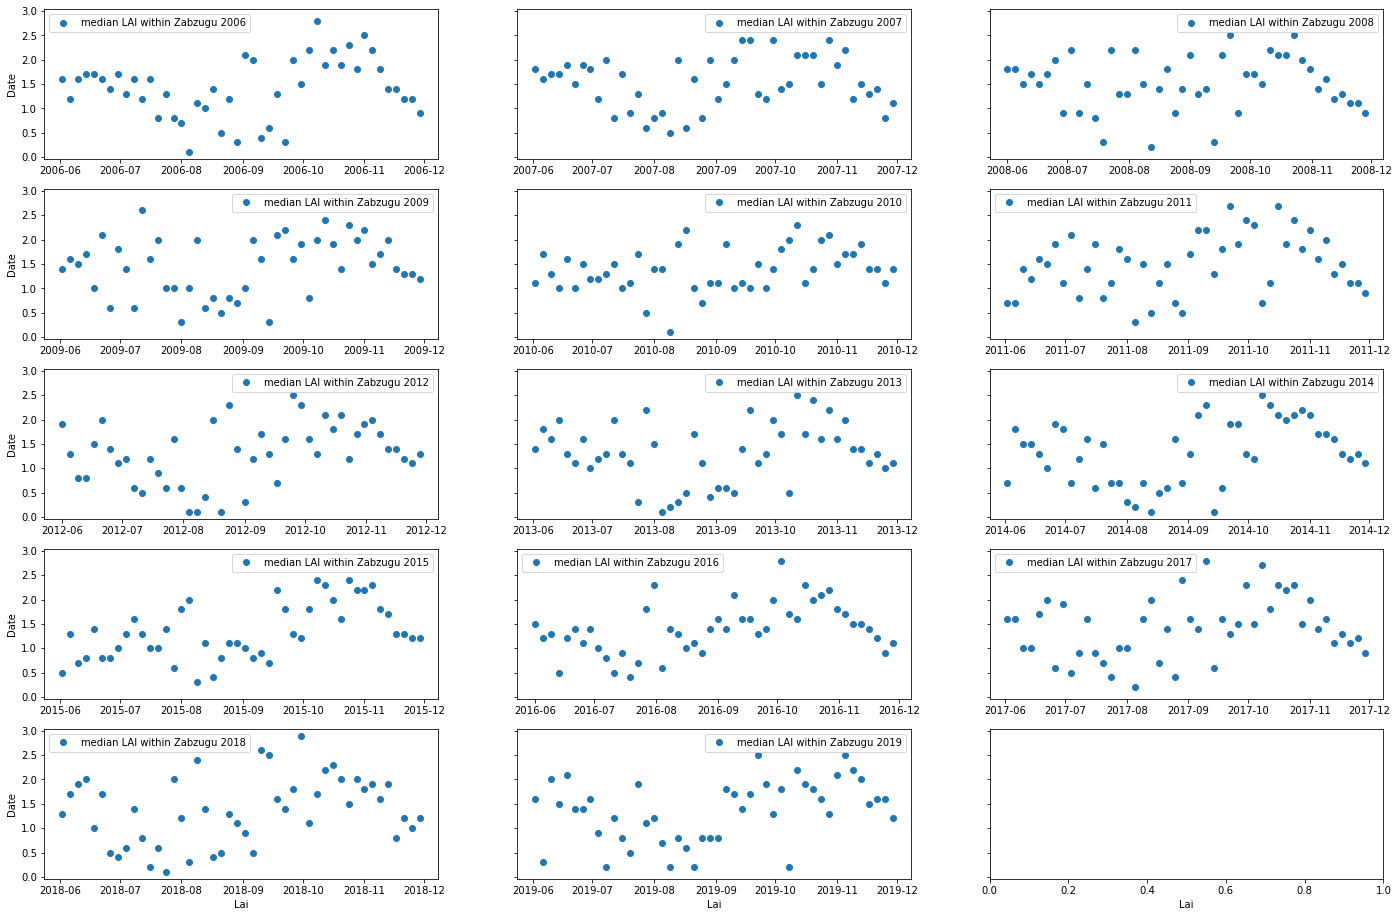

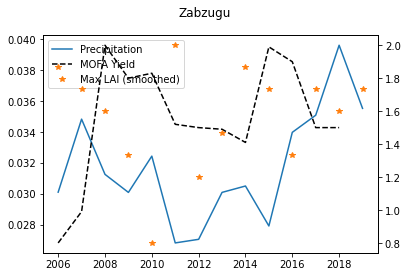

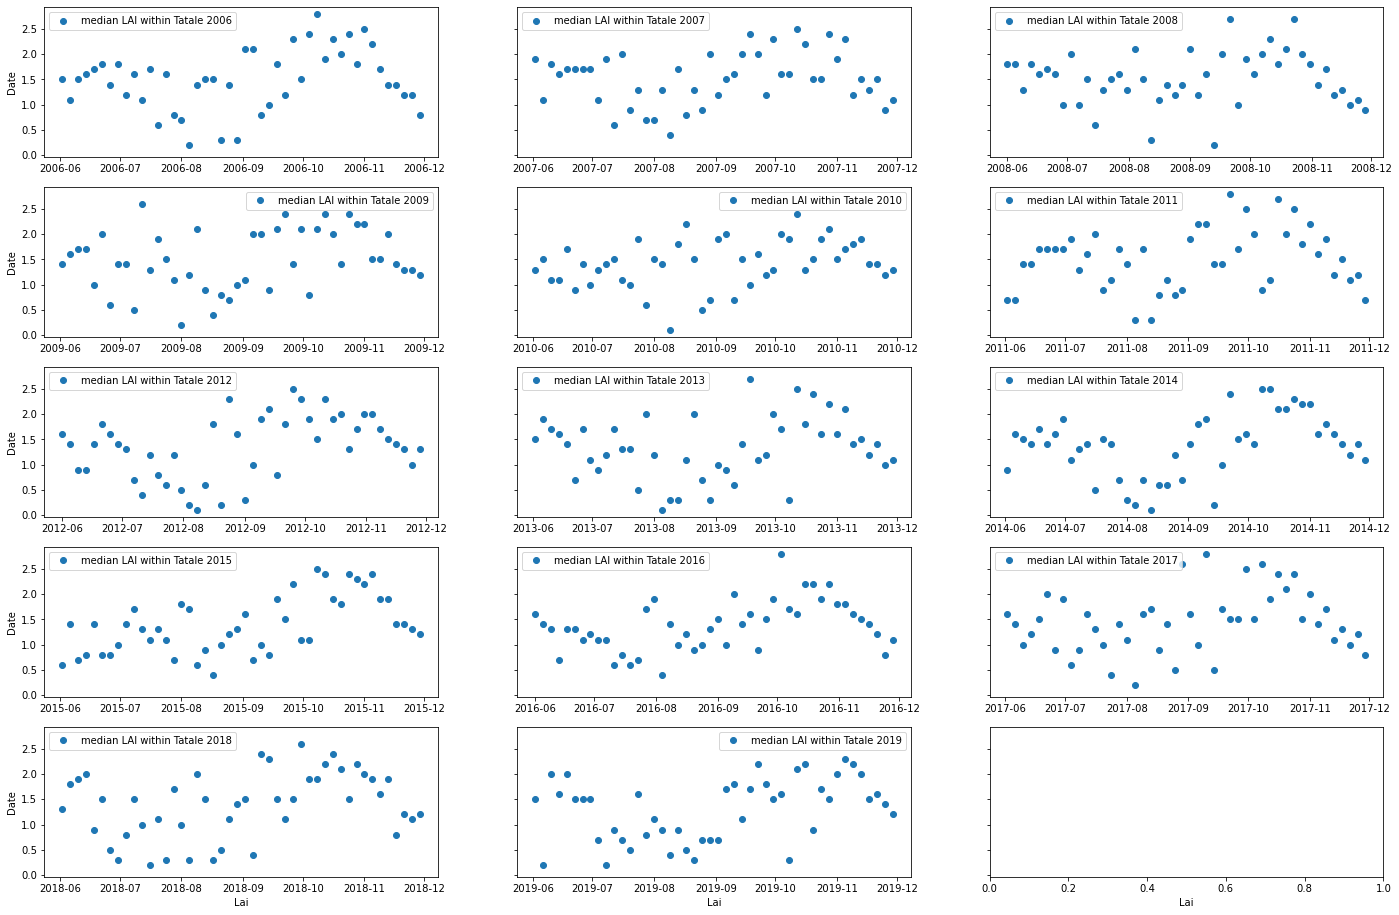

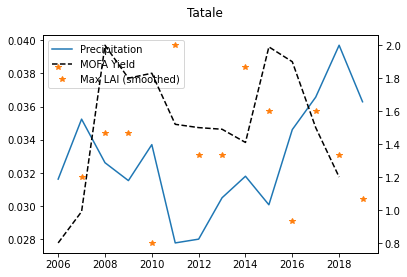

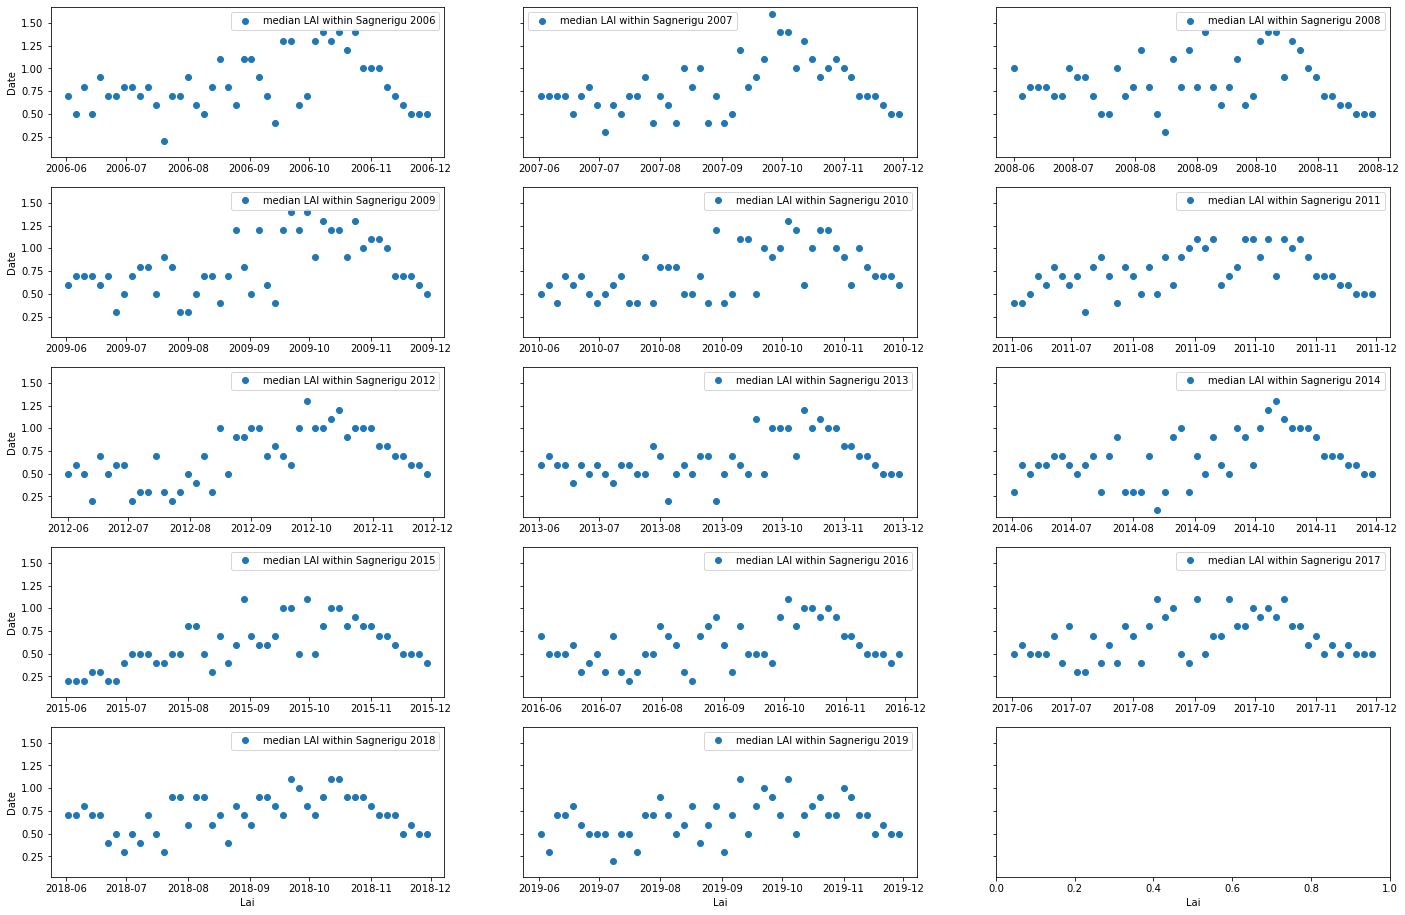

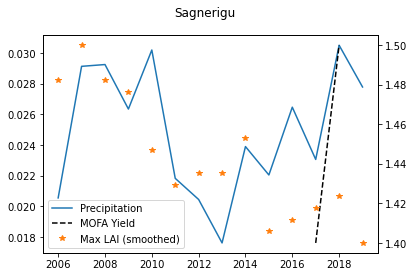

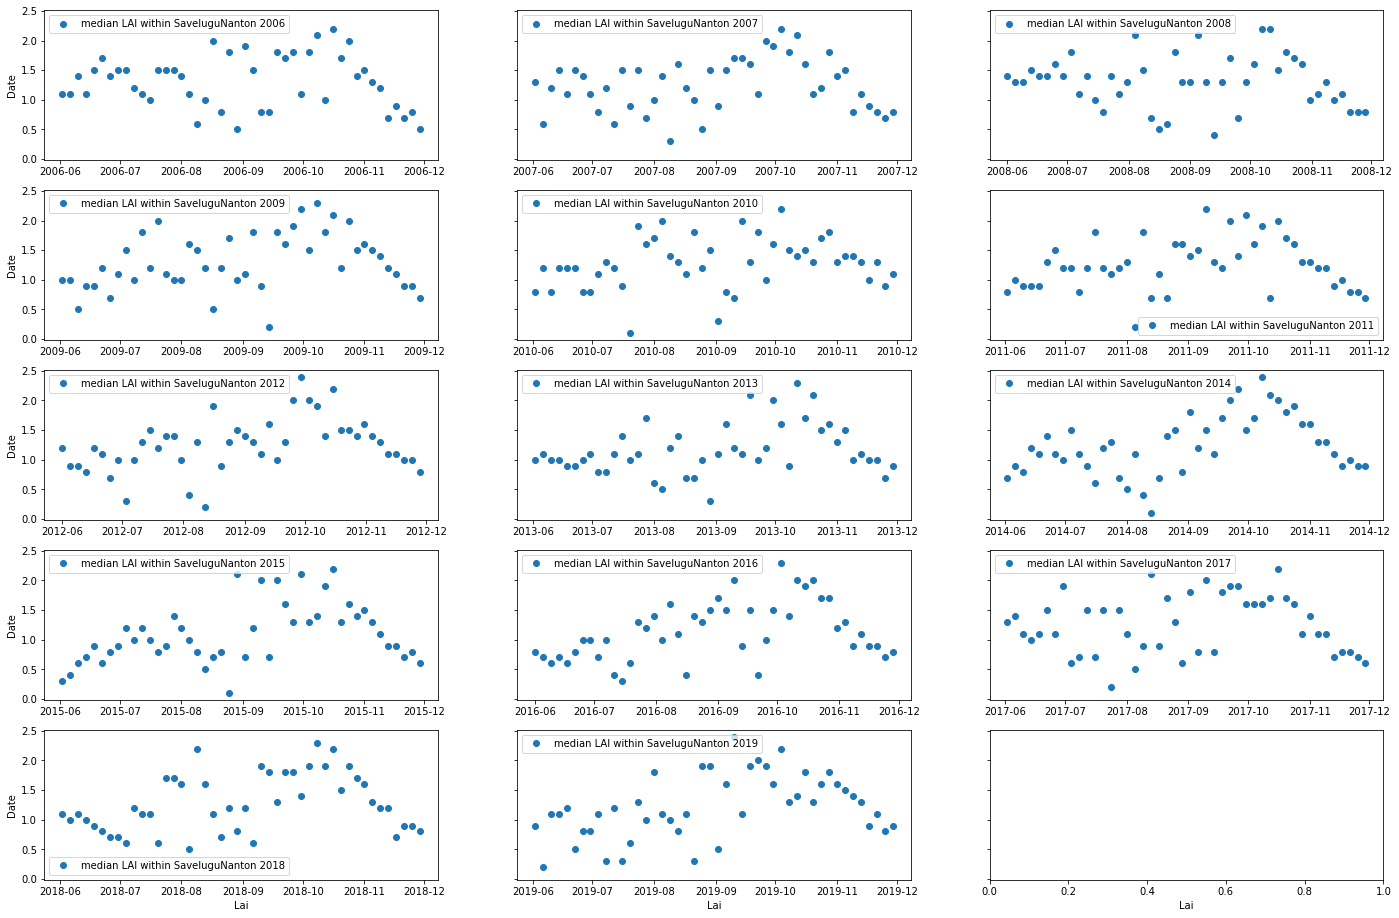

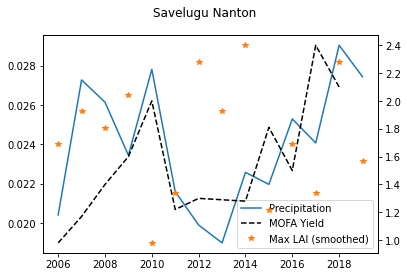

In [63]:
for dist in lai_per_district_2018.aggregate_array('ADM2_NAME').getInfo():
    print(dist)
    short_name = ''.join(dist.split(' ')).replace('/', '_')
    if exists(f'Qtrend_{short_name}.png'):
        print(f'Qtrend_{short_name}.png exists already.')
    else:
        plot_district_ts(district = dist)

## 3D plotting

Optional SPACE_REDUCED to make summary for each county at 500m resolution

(14, 46) (14, 46) (14, 46)


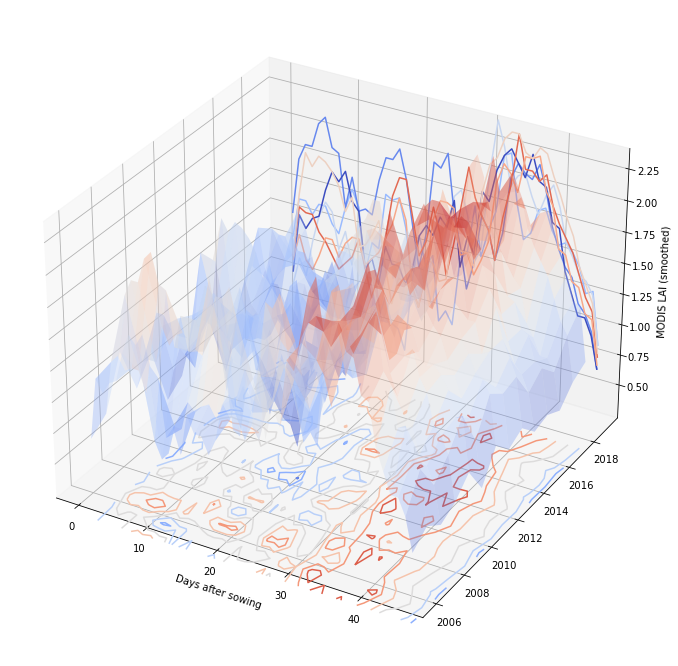

In [163]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')

X = np.tile(np.array(range(46)), (14, 1))     # doy #dates_all_seasons
Y = np.repeat(np.array(years).reshape(1,14), 46, axis=1).reshape(14,46)
Z = np.array(lai_smoothed) #lai_tamale_median_croplandonly
print(X.shape, Y.shape, Z.shape)

#cmap = cm.get_cmap("coolwarm")
#facecolors=cmap(colors)
ax.plot_surface(X, Y, Z, alpha=0.3, cmap=cm.coolwarm, ) #, rstride=8, cstride=8, 
cset = ax.contour(X, Y, Z, zdir='z', offset=0, cmap=cm.coolwarm)
#cset = ax.contour(X, Y, Z, zdir='x', offset=0, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='y', offset=2020, cmap=cm.coolwarm)

#cset = ax.plot(years, era5_prec)

ax.set_xlabel('Days after sowing')
#ax.set_ylabel('Year')
ax.set_zlabel('MODIS LAI (smoothed)')
#ax.set_zlim(0, 5)

plt.show()

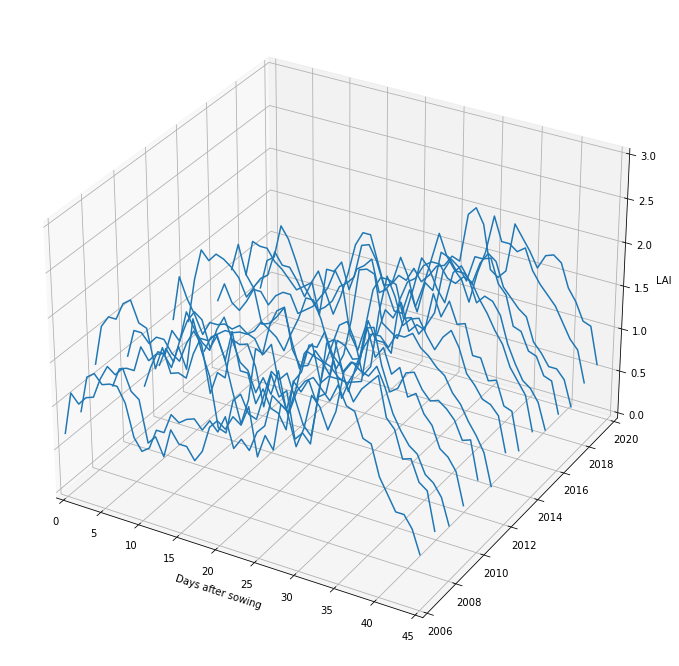

In [159]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.collections import PolyCollection, LineCollection
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors


def cc(arg):
    '''
    Shorthand to convert 'named' colors to rgba format at 60% opacity.
    '''
    return mcolors.to_rgba(arg, alpha=0.6)


fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')


# Make verts a list, verts[i] will be a list of (x,y) pairs defining polygon i
verts = []

# Set up the x sequence
xs = np.array(range(46))

# The ith polygon will appear on the plane y = zs[i]
zs = years

for i in zs:
    ys = np.array(lai_smoothed)[i-2006]
    verts.append(list(zip(xs, ys)))

facecolors = [cm.jet(x) for x in np.random.rand(14)]
poly = LineCollection(verts) #, facecolors=[cc('r'), cc('g'), cc('b'), cc('y')]
ax.add_collection3d(poly, zs=zs, zdir='y')



ax.set_xlabel('Days after sowing')
ax.set_xlim(0, 45)
#ax.set_ylabel('Year')
ax.set_ylim(2006, 2020)
ax.set_zlabel('LAI')
ax.set_zlim(0, 3)

plt.show()

# Interactive widgets in GEE

In [177]:
print(aoi_tamale.getInfo())

{'type': 'FeatureCollection', 'columns': {'ADM0_CODE': 'Integer', 'ADM0_NAME': 'String', 'ADM1_CODE': 'Integer', 'ADM1_NAME': 'String', 'ADM2_CODE': 'Integer', 'ADM2_NAME': 'String', 'DISP_AREA': 'String', 'EXP2_YEAR': 'Integer', 'STATUS': 'String', 'STR2_YEAR': 'Integer', 'Shape_Area': 'Float', 'Shape_Leng': 'Float', 'system:index': 'String'}, 'version': 1585342586965151, 'id': 'FAO/GAUL/2015/level2', 'properties': {'system:asset_size': 337701071}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-0.9634512226714054, 9.328631148082037], [-0.9634066079929557, 9.327632331009799], [-0.9631881279878065, 9.326660229778811], [-0.9633263454336152, 9.325969089460678], [-0.9631881279878065, 9.325380425012856], [-0.9631078658553346, 9.323766229824455], [-0.963152480209341, 9.321951416876026], [-0.9628938342687571, 9.32122008504081], [-0.9625014216236396, 9.319360635582573], [-0.962541588526929, 9.318856756279676], [-0.9624300543914515, 9.317750935776532], [-0.9

In [ ]:
poi_outline = ee.Image().byte().paint(**{
  'featureCollection': poi,
  'color': 1,
  'width': 2
})
#Map.addLayer(poi_outline)

marker = Marker(location=tamale_centre, draggable=False)
Map.add_layer(marker)



In [36]:
poi = ee.Geometry.Point(tamale_centre)

aoi_dist = cities.filterBounds(poi)
print(aoi_dist.getInfo())

polygon = ee.Image().byte().paint(**{'featureCollection': aoi_dist })
    
polygonIntersects = polygon.geometry().intersects(poi)
print(polygonIntersects.getInfo())

{'type': 'FeatureCollection', 'columns': {'ADM0_CODE': 'Integer', 'ADM0_NAME': 'String', 'ADM1_CODE': 'Integer', 'ADM1_NAME': 'String', 'ADM2_CODE': 'Integer', 'ADM2_NAME': 'String', 'DISP_AREA': 'String', 'EXP2_YEAR': 'Integer', 'STATUS': 'String', 'STR2_YEAR': 'Integer', 'Shape_Area': 'Float', 'Shape_Leng': 'Float', 'system:index': 'String'}, 'version': 1585342586965151, 'id': 'FAO/GAUL/2015/level2', 'properties': {'system:asset_size': 337701071}, 'features': [{'type': 'Feature', 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[9.135663550773264, -0.7337049776013317], [9.135922198715258, -0.7339635914446334], [9.135922198715258, -0.7337049461297347], [9.135663550773264, -0.7337049776013317]]], [[[9.1313070250779, -0.7120471111784357], [9.131565658928679, -0.7123057463852234], [9.131565658928679, -0.7120470954370753], [9.1313070250779, -0.7120471111784357]]], [[[9.12362396335327, -0.7174604597637247], [9.123882572340891, -0.7177190606974573], [9.124136791786192, -0.717719050234

True


In [17]:
Map = geemap.Map(center=farm_7021YAM, zoom=9)
Map.addLayer(outline, {}, 'Ghana districts')
lai_2018 = plot_modis_band(band='Lai', year=2018)

MODIS Lai and mean both SUCCESS for 2018


In [38]:
# Add an output widget to the map
output_widget = widgets.Output(layout={'border': '1px solid black'})
output_control = WidgetControl(widget=output_widget, position='bottomright')
Map.add_control(output_control)

file = open("Q1_dummy.jpg", "rb")
image = file.read()
dummy1 = widgets.Image(
    value=image,
    format='jpg',
    width=300,
    height=400,
)
image_widget = WidgetControl(widget=dummy1, position='topright')
Map.add_control(image_widget)

# Capture user interaction with the map
def handle_interaction(**kwargs):
    latlon = kwargs.get('coordinates')
    if kwargs.get('type') == 'click':
        Map.default_style = {'cursor': 'wait'}
        # xy = ee.Geometry.Point(latlon[::-1])     

        with output_widget:
            output_widget.clear_output()
            Map.remove_control(image_widget)
            print(latlon)
            #click_point = ee.Geometry.Point(coords.lon, coords.lat)
            
            poi = ee.Geometry.Point(latlon)
            aoi_dist = cities.filterBounds(poi)
            print(aoi_dist.get('ADM2_NAME').getInfo())
            polygon = ee.Image().byte().paint(**{'featureCollection': aoi_dist })
            polygonIntersects = polygon.geometry().intersects(poi)

            print(polygonIntersects.getInfo())
            Map.add_control(image_widget)
            
    Map.default_style = {'cursor': 'pointer'}


Map.on_interaction(handle_interaction)
Map

Map(bottom=31353.0, center=[9.38, -0.68], controls=(WidgetControl(options=['position', 'transparent_bg'], widg…

In [39]:
lai_per_district_2018 = modis_annual_vi_per_district(2018, 'Lai', northern_district, TIME_REDUCER='max', \
                            SPACE_DERUCER='median', CROPLAND_ONLY=True, ADD_TO_MAP=True)

MODIS Lai and mean both SUCCESS for 2018
MODIS LC_Type2 and mean both SUCCESS for 2018


In [40]:
print(lai_per_district_2018.aggregate_array('ADM2_NAME').getInfo()) #aggregate_array('ADM2_NAME')

['Gonja Central', 'Sawla/Tuna/Kalba', 'Bunkpurugu Yonyo', 'Mamprusi East', 'Bole', 'Karaga', 'Gushiegu', 'Nanumba North', 'Nanumba South', 'Chereponi', 'Kpandai', 'East Gonja', 'Saboba', 'North Gonja', 'West Gonja', 'Mion', 'Yendi Municipal', 'Tolon', 'Kumbumgu', 'West Mamprusi', 'Mamprugu Moagduri', 'Zabzugu', 'Tatale', 'Tamale North Sub Metro', 'Sagnerigu', 'Savelugu Nanton']


## Adding Climate data 
Monthly [ERA5 2m temperature](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_MONTHLY) is used here. It comes in a '0.1 arc degrees' resolution.

infor on crop calender of diff crops :
    https://cropcalendar.apps.fao.org/#/home 
        e.g. cumulated rainful 

Sagnerigu  does not have MOFA data
Sagnerigu  does not have MOFA data
Mion  does not have MOFA data
Mion  does not have MOFA data
North Gonja  does not have MOFA data
North Gonja  does not have MOFA data


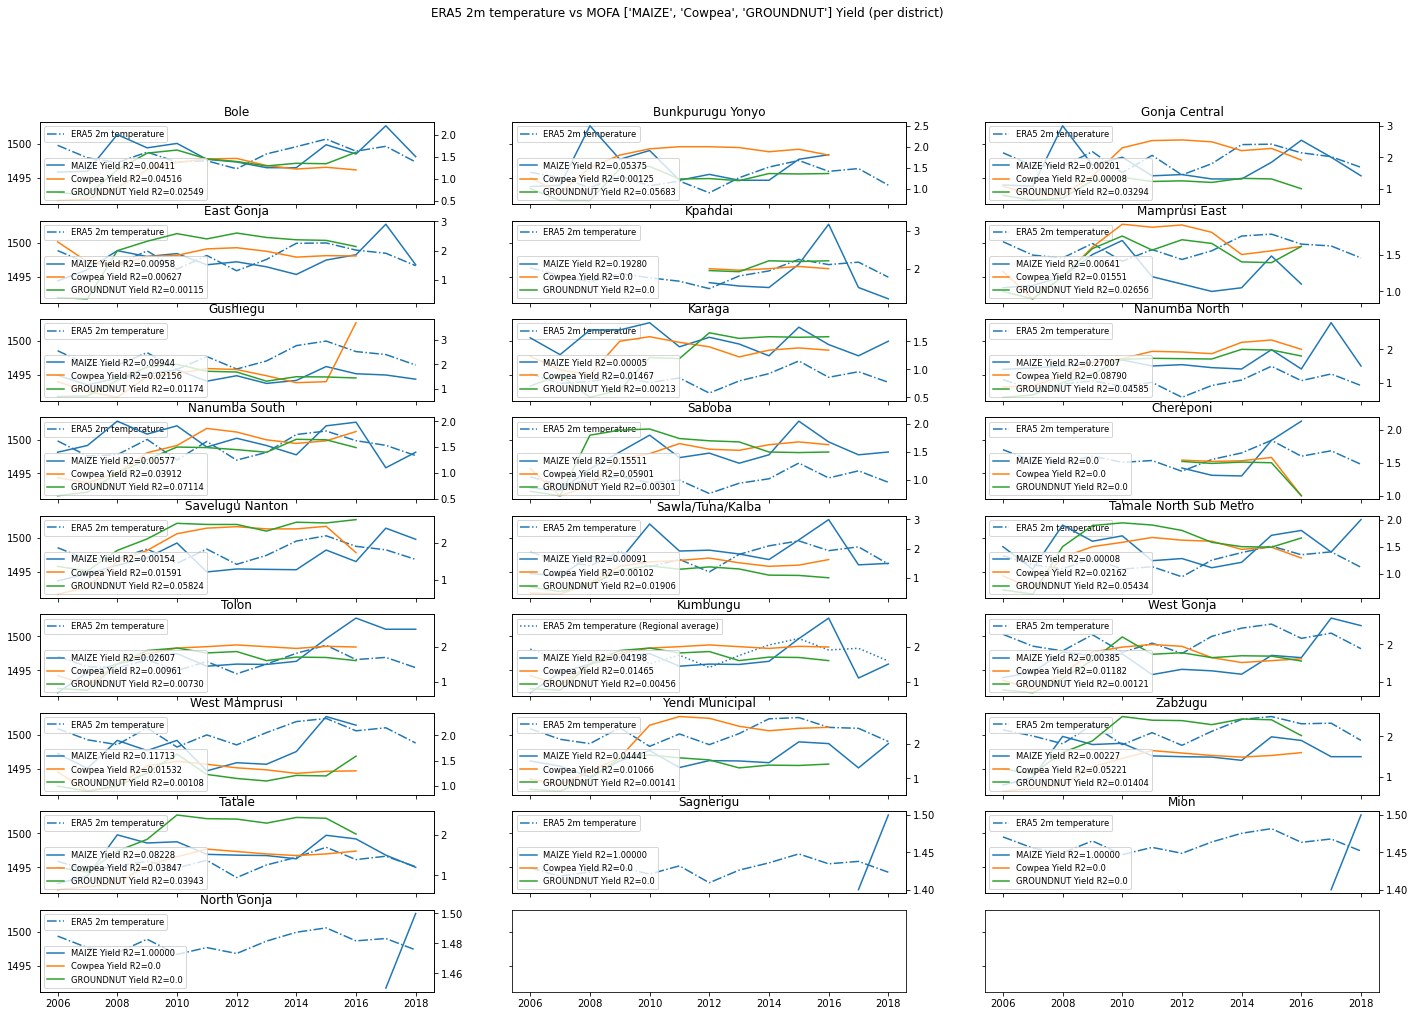

In [57]:
plot_gee_series_vs_mofa_yield(weather_district, weather_ts, \
                              df[df['REGION']=='NORTHERN'], crops=['MAIZE','Cowpea','GROUNDNUT'],\
                             series_name='ERA5 2m temperature', USE_REGIONAL_MEAN=True)

Nextly, we will plot other ERA5 bands as well, e.g. 'volumetric_soil_water_layer_1' is the volume of water in soil layer 1 **(0 - 7 cm)** of the ECMWF Integrated Forecasting System. Other bands e.g. **'evaporation_from_bare_soil' or 'leaf_area_index_high_vegetation' could also be included**

Plotting total_precipitation...
No. of districts:  26 ; No. of years:  13
Sagnerigu  does not have MOFA data
Sagnerigu  does not have MOFA data
Mion  does not have MOFA data
Mion  does not have MOFA data
North Gonja  does not have MOFA data
North Gonja  does not have MOFA data
Plotting volumetric_soil_water_layer_1...
No. of districts:  26 ; No. of years:  13
Sagnerigu  does not have MOFA data
Sagnerigu  does not have MOFA data
Mion  does not have MOFA data
Mion  does not have MOFA data
North Gonja  does not have MOFA data
North Gonja  does not have MOFA data
Plotting evaporation_from_bare_soil...
No. of districts:  26 ; No. of years:  13
Sagnerigu  does not have MOFA data
Sagnerigu  does not have MOFA data
Mion  does not have MOFA data
Mion  does not have MOFA data
North Gonja  does not have MOFA data
North Gonja  does not have MOFA data
Plotting leaf_area_index_high_vegetation...
No. of districts:  26 ; No. of years:  13


/Users/qingling/opt/anaconda3/envs/gee/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/qingling/opt/anaconda3/envs/gee/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/qingling/opt/anaconda3/envs/gee/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/qingling/opt/anaconda3/envs/gee/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/qingling/opt/anaconda3/envs/gee/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/qingling/opt/anaconda3/envs/gee/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: 

Sagnerigu  does not have MOFA data
Sagnerigu  does not have MOFA data
Mion  does not have MOFA data
Mion  does not have MOFA data
North Gonja  does not have MOFA data
North Gonja  does not have MOFA data


/Users/qingling/opt/anaconda3/envs/gee/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/qingling/opt/anaconda3/envs/gee/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


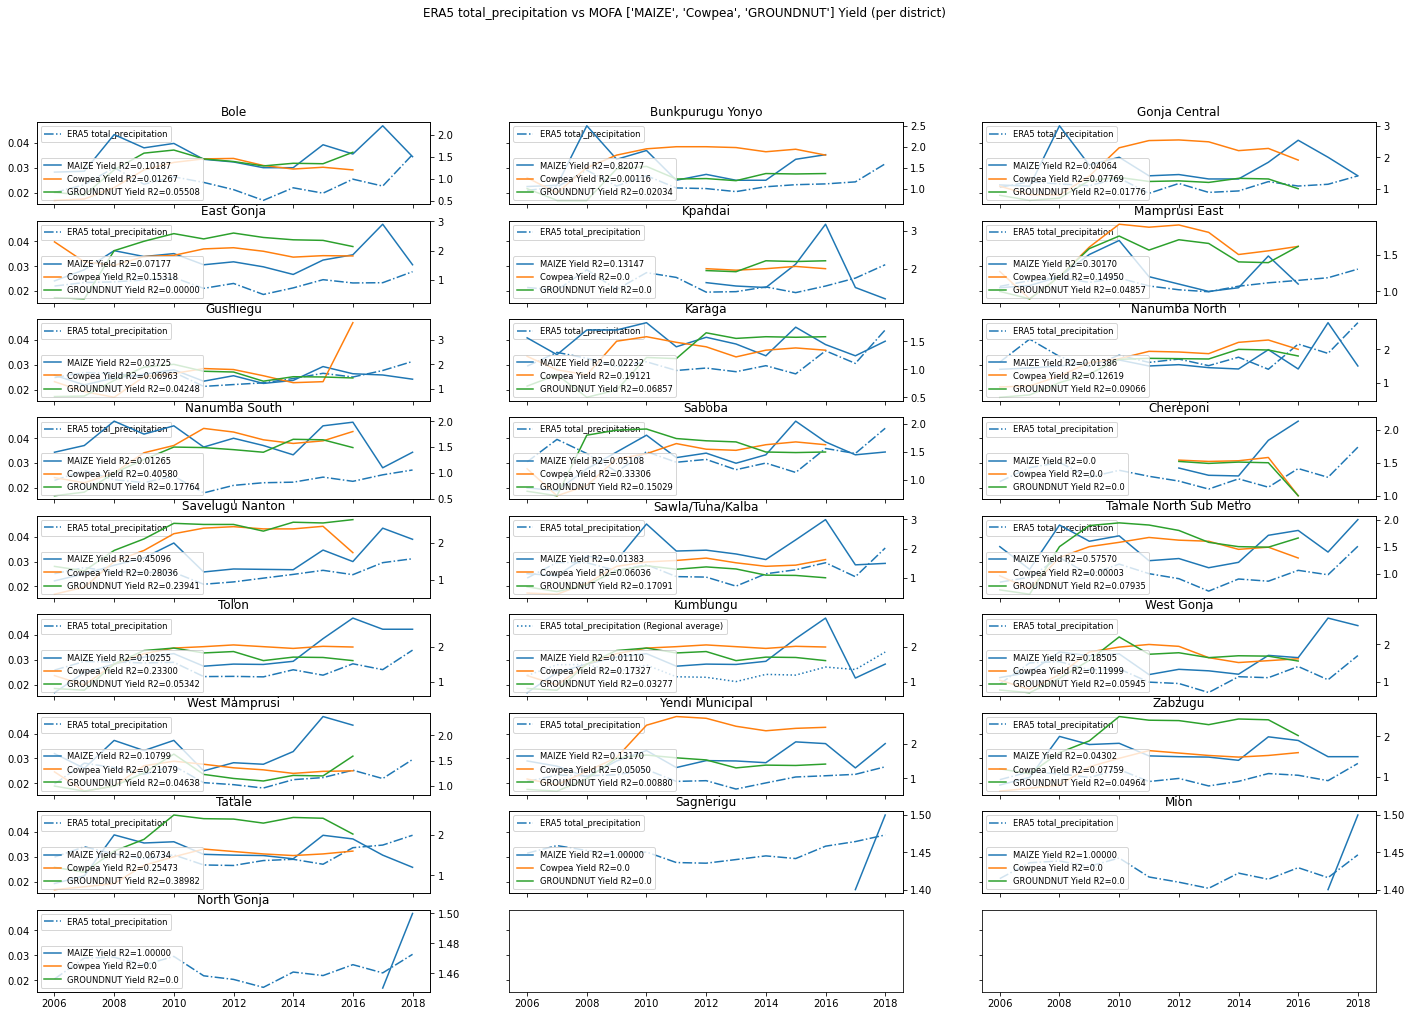

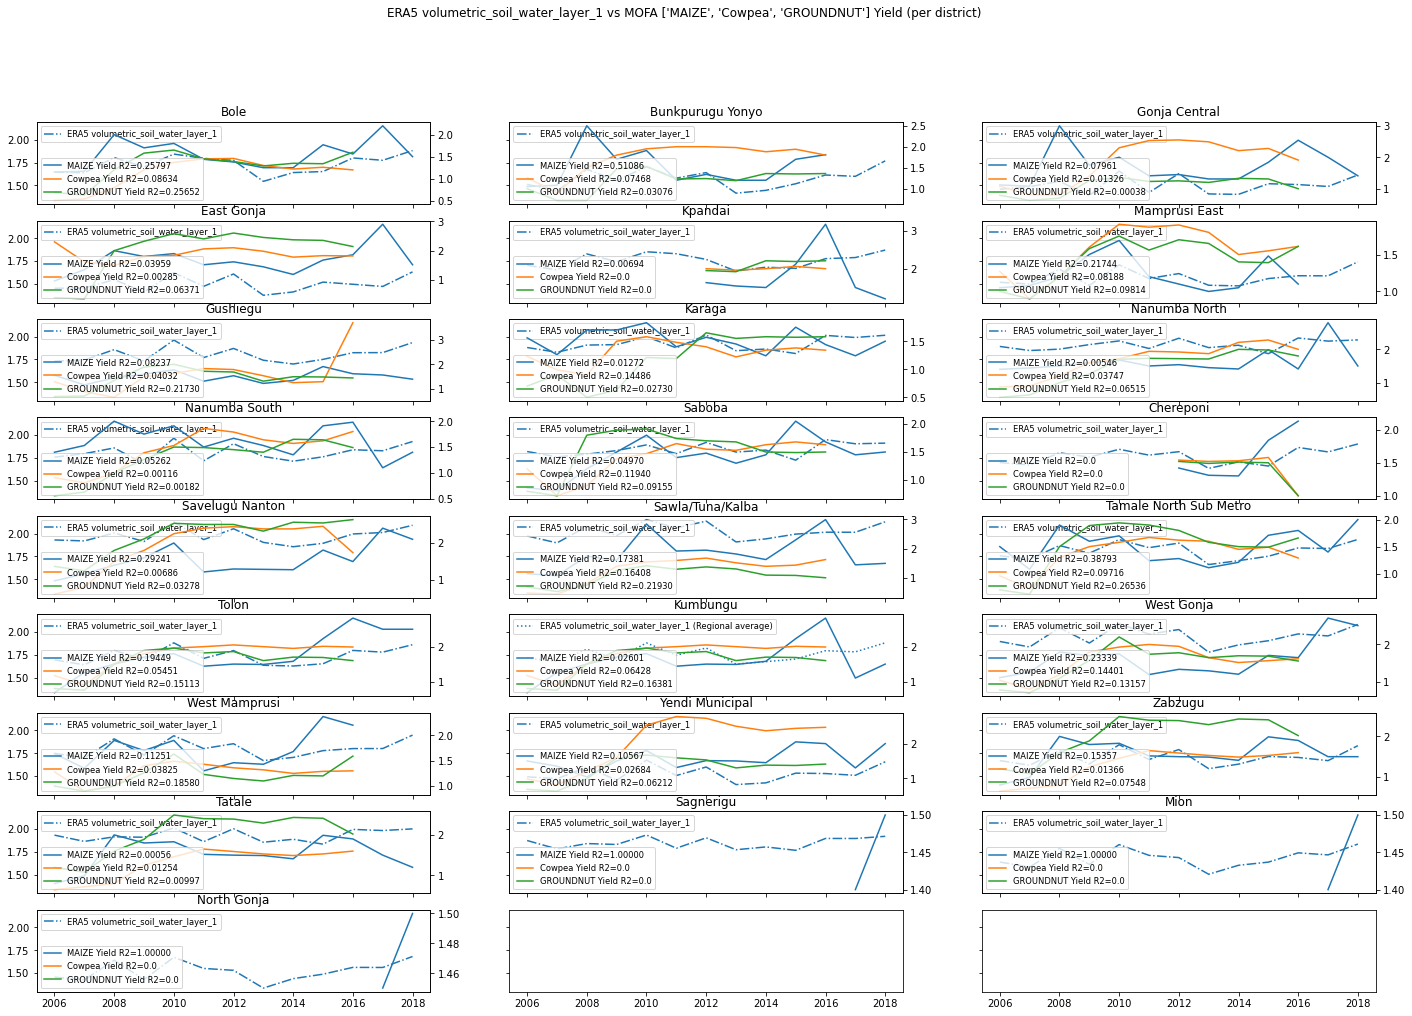

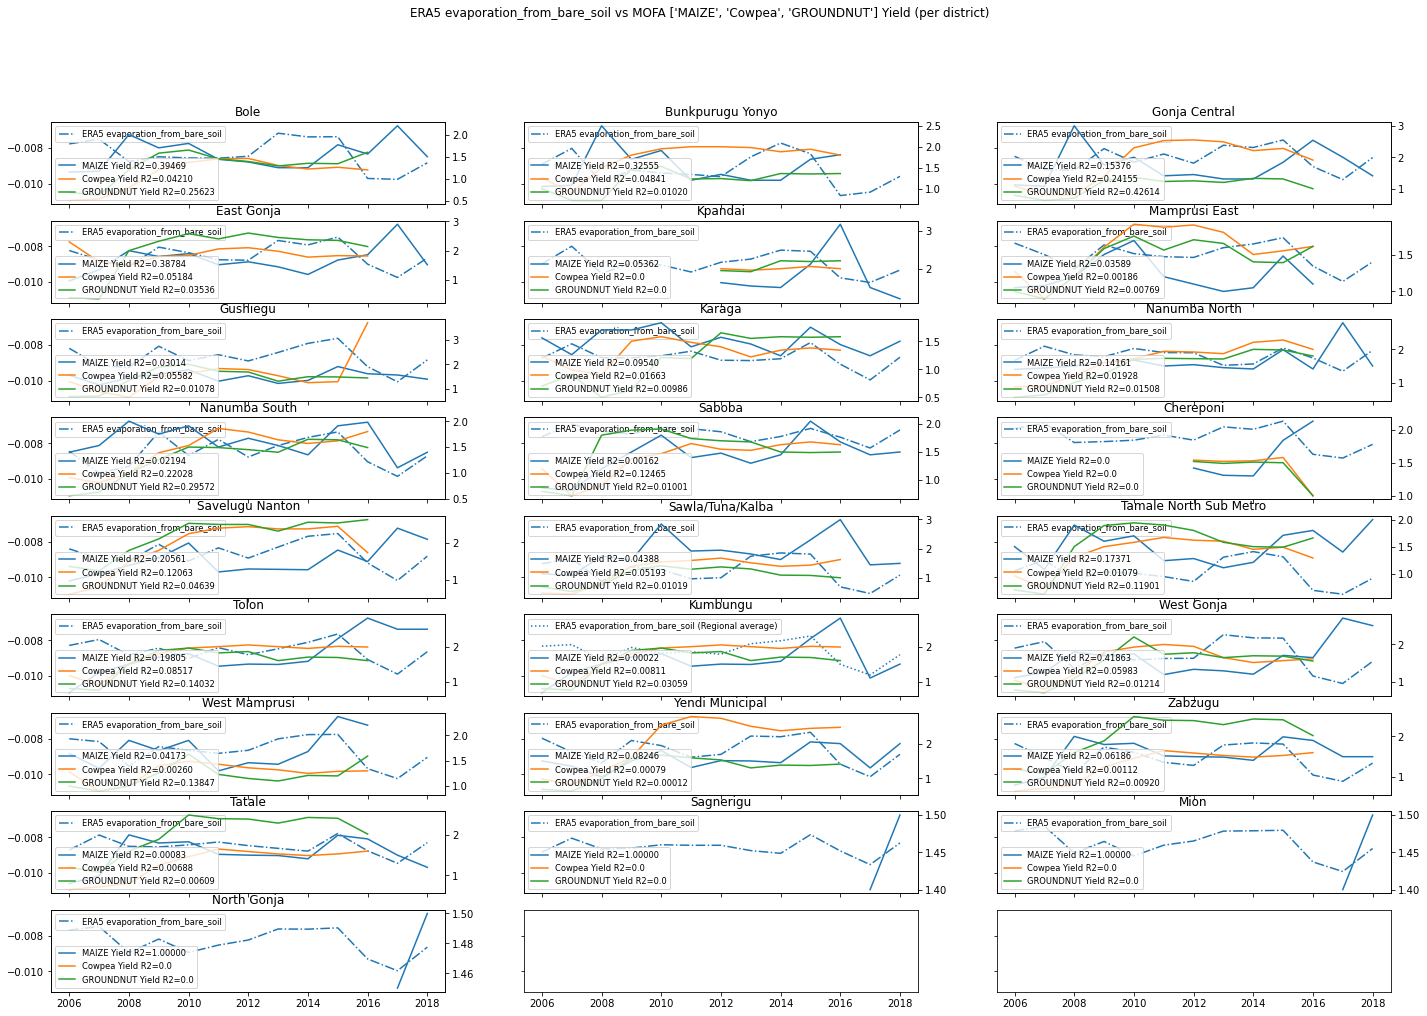

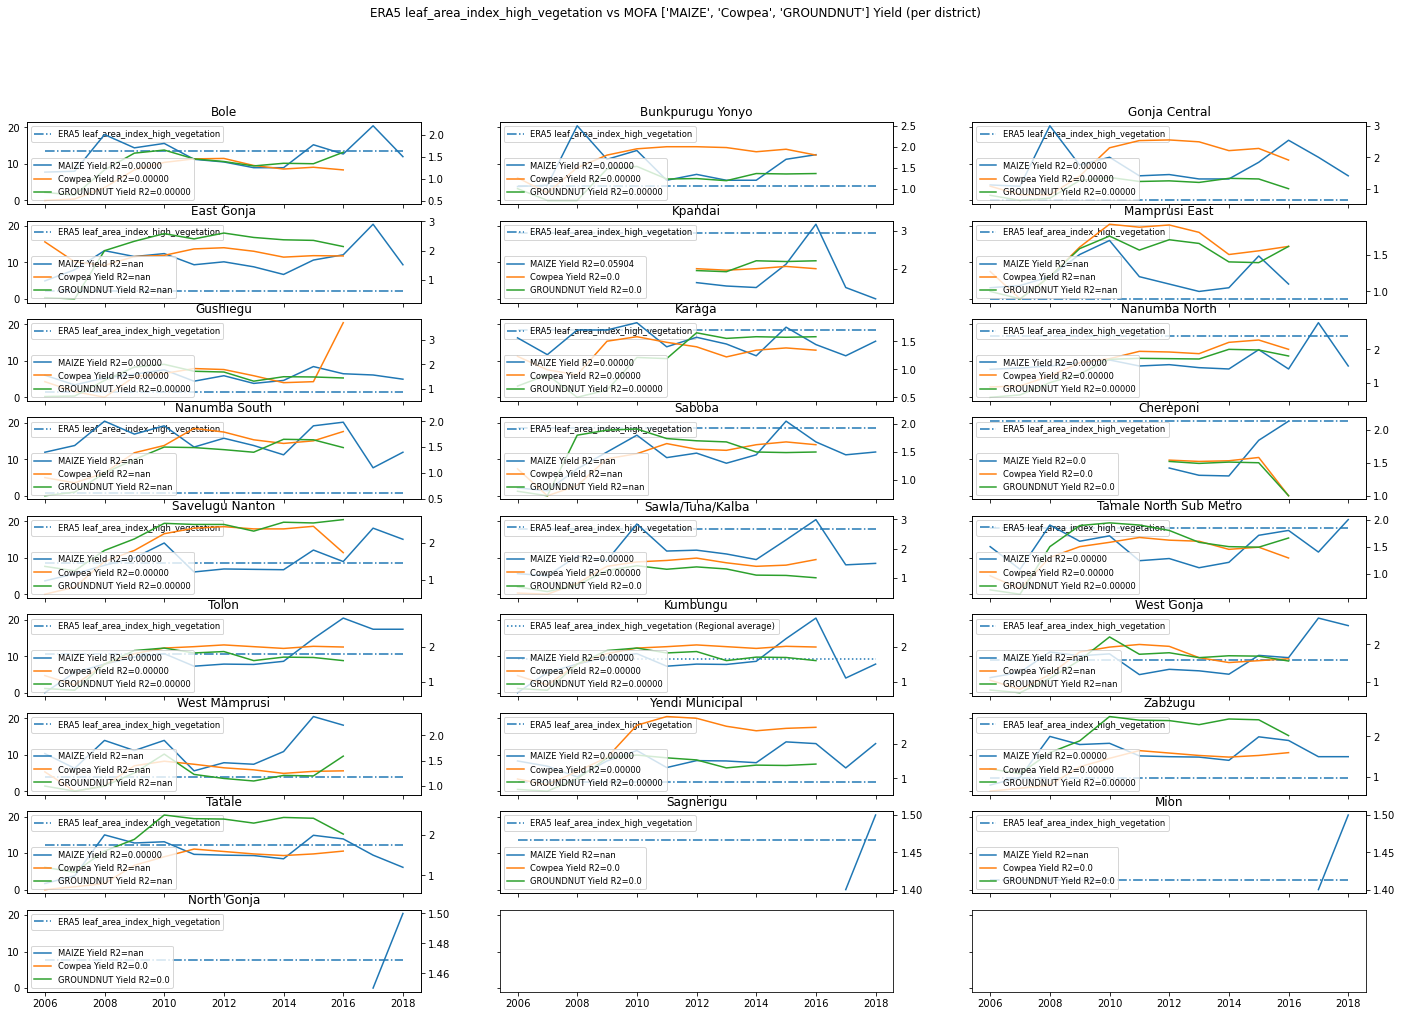

In [58]:
era5_bands = ['total_precipitation', 'volumetric_soil_water_layer_1', \
              'evaporation_from_bare_soil', 'leaf_area_index_high_vegetation']

for band in era5_bands:
    print(f'Plotting {band}...')
    weather_district, weather_ts = era5_ts_per_district(range(MIN_YEAR,END_YEAR+1), northern_district, \
                                                        band=band)
    plot_gee_series_vs_mofa_yield(weather_district, weather_ts, \
                              df[df['REGION']=='NORTHERN'], crops=['MAIZE','Cowpea','GROUNDNUT'],\
                             series_name='ERA5 '+ band, USE_REGIONAL_MEAN=True)

Based on the previous plots, 'leaf_area_index_high_vegetation' seems to have little data, so let's drop it. The other three bands have high colinearity, so let's just work on one of them for now.

Retreiving ERA5 monthly temperature_2m...
No. of districts:  26 ; No. of years:  13
338 (1, 26, 13)
Retreiving ERA5 monthly total_precipitation...
No. of districts:  26 ; No. of years:  13
338
676 (2, 26, 13)
Retreiving ERA5 monthly evaporation_from_bare_soil...
No. of districts:  26 ; No. of years:  13
338
1014 (3, 26, 13)
Gonja Central -95.54506530136267 [ 6.25494915e-02  1.97528217e+01 -3.66396457e+02]
Sawla/Tuna/Kalba -61.432919948786555 [ 4.07767724e-02 -1.93763328e+00 -2.55520317e+02]
Not enough MOFA YIELD for Bunkpurugu Yonyo
Not enough MOFA YIELD for Mamprusi East
Bole -118.83479098430556 [ 7.87608075e-02  2.53939699e+01 -2.23578291e+02]
Karaga 89.45001980287768 [-5.80276684e-02  2.54508164e+01  1.82753065e+02]
Gushiegu -68.86030123417886 [ 0.04680426 19.97066091 27.72731482]
Nanumba North -236.37828314821158 [ 1.57002989e-01 -5.75569173e+00 -4.06734713e+02]
Nanumba South 1.0508652902612305 [ 3.18739165e-03 -1.81398243e+01  4.14886911e+02]
Not enough MOFA YIELD for Chereponi
No

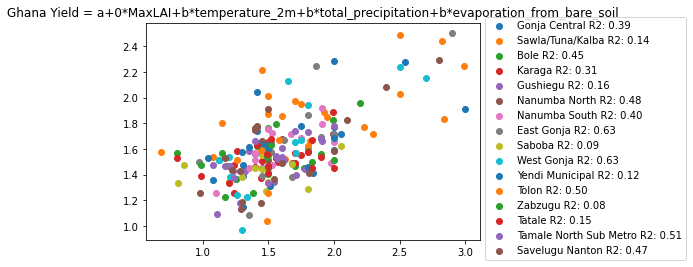

In [64]:
linreg_era5_with_yield(df_northern_maize, ['temperature_2m', 'total_precipitation',\
                                           'evaporation_from_bare_soil'], VERBOSE=False)